In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import os
import matplotlib.pyplot as plt
import zlib
import sys
import compress
import random
import lzma
import math

In [2]:
from compress import Compressor
c = Compressor()
c.use_zlib()

In [3]:
data_df = pd.read_csv('C1_160308.txt', sep=",", engine='python')
data_df.columns = ['Time', 'X', 'Y', 'Z']
# data_df.astype({'Y': 'float64'})

In [4]:
data_df = data_df.dropna()
data_df.isnull().sum()

Time    0
X       0
Y       0
Z       0
dtype: int64

In [5]:
data_df['X'] = round(data_df['X']/0.0078125)
data_df['Y'] = round(data_df['Y']/0.0078125)
data_df['Z'] = round(data_df['Z']/0.0078125)
data_df = data_df.astype({'X': 'int16',
               'Y': 'int16',
               'Z': 'int16'})
data_df.dtypes

Time    object
X        int16
Y        int16
Z        int16
dtype: object

In [6]:
data_df

,Time,X,Y,Z
0,1457463019.235153113,-522,1243,23
1,1457463019.250019832,-513,1259,22
2,1457463019.264886551,-513,1283,13
3,1457463019.279753270,-513,1315,-2
4,1457463019.294619989,-515,1309,-2
...,...,...,...,...
724656,1457473792.429142167,-542,1374,-167
724657,1457473792.444008886,-536,1404,-184
724658,1457473792.458875605,-534,1375,-179
724659,1457473792.473742324,-531,1361,-185


In [7]:
data_df.isnull().sum()

Time    0
X       0
Y       0
Z       0
dtype: int64

In [8]:
data_df.dtypes

Time    object
X        int16
Y        int16
Z        int16
dtype: object

In [9]:
data_df = data_df.astype({'Time': 'float64'})
data_df.dtypes

Time    float64
X         int16
Y         int16
Z         int16
dtype: object

# 1 second, vary zlib level, measure final size of data (check time for compression later)
# ALSO THIS IS FOR SINGLE LIST COMPRESSION NOT 3D ARRAY

In [29]:
start = random.randint(0, 650000)
df_chunk = data_df[start: start+64]

In [69]:
time = np.array(df_chunk['Time'].tolist())
x_values = np.array(df_chunk['X'].tolist())
y_values = np.array(df_chunk['Y'].tolist())
z_values = np.array(df_chunk['Z'].tolist())
x_values

array([-65547, -65469, -65391, -65781, -65938, -65859, -65703, -65391,
       -65625, -65938, -65859, -66016, -65938, -65859, -65625, -65859,
       -66250, -65703, -65781, -65859, -65625, -65781, -65859, -66016,
       -66016, -66562, -66250, -66406, -66172, -66328, -66562, -66172,
       -66250, -66406, -66094, -66797, -66641, -66406, -66250, -66328,
       -66328, -66484, -66406, -66406, -66172, -66172, -66562, -66641,
       -65859, -66172, -66641, -66562, -66328, -66875, -66641, -66875,
       -66875, -66953, -66484, -66562, -66562, -66953, -66953, -66875])

In [117]:
comp_x = [str(x) for x in x_values]
comp_x = ','.join(comp_x)
initial = comp_x.split(',')

comp_x = zlib.compress(bytes(comp_x.encode('utf-8')), 9)
decomp_x = zlib.decompress(comp_x).decode()
final = decomp_x.split(',')
print(initial == final)

True


In [120]:
def compressed_size(values_array, level):
    values = [str(x) for x in values_array]
    values_str = ','.join(values)
    initial = values_str.split(',')
    
    comp_values = zlib.compress(bytes(values_str.encode('utf-8')), level)
    decomp_values = zlib.decompress(comp_values).decode()
    final = decomp_values.split(',')
    if not initial == final:
        raise Exception('Decompressed does not equal compressed')
    return sys.getsizeof(comp_values)

In [190]:
# use zlib levels of 1, 5, 9
uncomp_values = []
comp_values1 = []
comp_values5 = []
comp_values9 = []

comp_values_t1 = []
comp_values_t5 = []
comp_values_t9 = []

comp_values_x1 = []
comp_values_x5 = []
comp_values_x9 = []

comp_values_y1 = []
comp_values_y5 = []
comp_values_y9 = []

comp_values_z1 = []
comp_values_z5 = []
comp_values_z9 = []

for i in range(10000):
    start = random.randint(0, 650000)
    df_chunk = data_df[start: start+64]
    
    time = np.array(df_chunk['Time'].tolist())
    x_values = np.array(df_chunk['X'].tolist())
    y_values = np.array(df_chunk['Y'].tolist())
    z_values = np.array(df_chunk['Z'].tolist())
    
    uncomp_values.append(sys.getsizeof(time) +
                        sys.getsizeof(x_values) +
                        sys.getsizeof(y_values) +
                        sys.getsizeof(z_values))
    
    comp_values_t1.append(compressed_size(time, 1))
    comp_values_t5.append(compressed_size(time, 5))
    comp_values_t9.append(compressed_size(time, 9))
    
    comp_values_x1.append(compressed_size(x_values, 1))
    comp_values_x5.append(compressed_size(x_values, 5))
    comp_values_x9.append(compressed_size(x_values, 9))
    
    comp_values_y1.append(compressed_size(y_values, 1))
    comp_values_y5.append(compressed_size(y_values, 5))
    comp_values_y9.append(compressed_size(y_values, 9))
    
    comp_values_z1.append(compressed_size(z_values, 1))
    comp_values_z5.append(compressed_size(z_values, 5))
    comp_values_z9.append(compressed_size(z_values, 9))
    
    total1 = sys.getsizeof(compressed_size(time, 1))+sys.getsizeof(compressed_size(x_values, 1))+sys.getsizeof(compressed_size(y_values, 1))+sys.getsizeof(compressed_size(z_values, 1))
    total5 = sys.getsizeof(compressed_size(time, 5))+sys.getsizeof(compressed_size(x_values, 5))+sys.getsizeof(compressed_size(y_values, 5))+sys.getsizeof(compressed_size(z_values, 5))
    total9 = sys.getsizeof(compressed_size(time, 9))+sys.getsizeof(compressed_size(x_values, 9))+sys.getsizeof(compressed_size(y_values, 9))+sys.getsizeof(compressed_size(z_values, 9))
    
    comp_values1.append(total1)
    
    comp_values5.append(total5)
    
    comp_values9.append(total9)
    

In [197]:
print(min(uncomp_values), max(uncomp_values))
print(min(comp_values1), max(comp_values1))
print(min(comp_values9), max(comp_values9))
print(min(comp_values9), max(comp_values9))

1664 1664
112 112
112 112
112 112


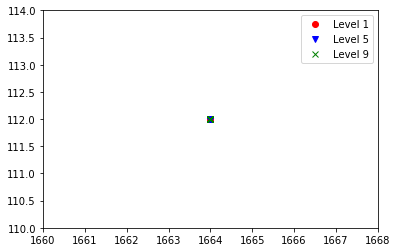

In [192]:
plt.plot(uncomp_values, comp_values1, 'ro', label='Level 1')
plt.plot(uncomp_values, comp_values5, 'bv', label='Level 5')
plt.plot(uncomp_values, comp_values9, 'gx', label='Level 9')
plt.axis([1660, 1668, 110, 114])
plt.legend()
plt.show()

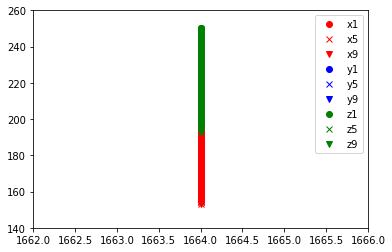

In [193]:
plt.plot(uncomp_values, comp_values_x1, 'ro', label='x1')
plt.plot(uncomp_values, comp_values_x5, 'rx', label='x5')
plt.plot(uncomp_values, comp_values_x9, 'rv', label='x9')
plt.plot(uncomp_values, comp_values_y1, 'bo', label='y1')
plt.plot(uncomp_values, comp_values_y5, 'bx', label='y5')
plt.plot(uncomp_values, comp_values_y9, 'bv', label='y9')
plt.plot(uncomp_values, comp_values_z1, 'go', label='z1')
plt.plot(uncomp_values, comp_values_z5, 'gx', label='z5')
plt.plot(uncomp_values, comp_values_z9, 'gv', label='z9')
plt.axis([1662, 1666, 140, 260])
plt.legend()
plt.show()

# LZMA

In [199]:
comp_x = [str(x) for x in x_values]
comp_x = ','.join(comp_x)
initial = comp_x.split(',')

comp_x = lzma.compress(bytes(comp_x.encode('utf-8')))
decomp_x = lzma.decompress(comp_x).decode()
final = decomp_x.split(',')
print(initial == final)
print(sys.getsizeof(initial))
print(sys.getsizeof(comp_x))

True
576
277


In [171]:
comp_x = [str(x) for x in x_values]
comp_x = ','.join(comp_x)
initial = comp_x.split(',')

comp_x = snappy.compress(bytes(comp_x.encode('utf-8')))
decomp_x = snappy.decompress(comp_x).decode()
final = decomp_x.split(',')
print(initial == final)
# print(initial)
# print(final)

AttributeError: module 'snappy' has no attribute 'compress'

# RANDOM

In [7]:
st = '1'
print(''.join('{0:014b}'.format(ord(x), 'b') for x in st))
print('{0:014b}'.format(-3))

00000000110001
-0000000000011


In [8]:
data_df.describe()

,X,Y,Z
count,710907.000000,710907.000000,710907.000000
mean,-798.749368,1045.176643,-100.195964
std,183.360972,478.466824,485.161339
min,-1279.000000,-485.000000,-1433.000000
25%,-883.000000,598.000000,-554.000000
50%,-822.000000,1046.000000,-99.000000
75%,-713.000000,1493.500000,354.000000
max,47.000000,2325.000000,1144.000000


In [18]:
t_values = data_df['Time'].tolist()
x_values = data_df['X'].tolist()
y_values = data_df['Y'].tolist()
z_values = data_df['Z'].tolist()
type(x_values)

list

In [11]:
def difference_coding(number_of_values, values, start_num):
    num_of_readings = number_of_values
    full_values = values[start_num: start_num + num_of_readings]
    

In [12]:
codes={}

def frequency (str) :
    freqs = {}
    for ch in str :
        freqs[ch] = freqs.get(ch,0) + 1
    return freqs

def sortFreq (freqs) :
    letters = freqs.keys()
    tuples = []
    for let in letters :
        tuples.append((freqs[let],let))
    tuples.sort()
    return tuples

def buildTree(tuples) :
    while len(tuples) > 1 :
        leastTwo = tuple(tuples[0:2])                  # get the 2 to combine
        theRest  = tuples[2:]                          # all the others
        combFreq = leastTwo[0][0] + leastTwo[1][0]     # the branch points freq
        tuples   = theRest + [(combFreq,leastTwo)]     # add branch point to the end
#         print(tuples)
        tuples.sort(key=lambda t: t[0])                                  # sort it into place
    return tuples[0]            # Return the single tree inside the list

def trimTree (tree) :
     # Trim the freq counters off, leaving just the letters
    p = tree[1]                                    # ignore freq count in [0]
    if type(p) == type("") : return p              # if just a leaf, return it
    else : return (trimTree(p[0]), trimTree(p[1])) # trim left then right and recombine
    
def assignCodes (node, pat='') :
    global codes
    if type(node) == type("") :
        codes[node] = pat                # A leaf. set its code
    else  :                              #
        assignCodes(node[0], pat+"0")    # Branch point. Do the left branch
        assignCodes(node[1], pat+"1")    # then do the right branch.

def encode_str (str) :
    global codes
    output = ""
    for ch in str : output += codes[ch]
    return output

def decode_str (tree, string_to_decode) :
    output = ""
    p = tree
    for bit in string_to_decode:
#         print(bit, type(bit), p)
        if bit == '0' : p = p[0]     # Head up the left branch
        else          : p = p[1]     # or up the right branch
        if type(p) == type("") :
            output += p              # found a character. Add to output
            p = tree                 # and restart for next character
    return output

original_str = 'aaabccdeeeeeffg'
qwe = frequency('aaabccdeeeeeffg')
print('frequencies:', qwe)
print('-'*20)
tuples_for_tree = sortFreq(qwe)
print('sorted freq:', tuples_for_tree)
print('-'*20)
tree = buildTree(tuples_for_tree)
print('tree:', tree)
print('-'*20)
trimmed = trimTree(tree)
print('trimmed tree:', trimmed)
print('-'*20)
assignCodes(trimmed)
print('assignment of codes:', codes)
print('-'*20)
print('encoded:', encode_str('aaabccdeeeeeffg'))
print('-'*20)
decoded = decode_str(trimmed, '000000101001101110111111111111100100010')
print('decoded:', decoded)
print('-'*20)
print('Original matches decoded:', decoded == original_str)

frequencies: {'a': 3, 'b': 1, 'c': 2, 'd': 1, 'e': 5, 'f': 2, 'g': 1}
--------------------
sorted freq: [(1, 'b'), (1, 'd'), (1, 'g'), (2, 'c'), (2, 'f'), (3, 'a'), (5, 'e')]
--------------------
tree: (15, ((6, ((3, 'a'), (3, ((1, 'g'), (2, 'c'))))), (9, ((4, ((2, 'f'), (2, ((1, 'b'), (1, 'd'))))), (5, 'e')))))
--------------------
trimmed tree: (('a', ('g', 'c')), (('f', ('b', 'd')), 'e'))
--------------------
assignment of codes: {'a': '00', 'g': '010', 'c': '011', 'f': '100', 'b': '1010', 'd': '1011', 'e': '11'}
--------------------
encoded: 000000101001101110111111111111100100010
--------------------
decoded: aaabccdeeeeeffg
--------------------
Original matches decoded: True


In [14]:
start = random.randint(0, 650000)
num_of_readings = 70
initial = x_values[start]
full_values = x_values[start: start+num_of_readings]
full_joined = ','.join(map(str, full_values))
new = []
for i in range(start, start+num_of_readings):
    new.append(x_values[i]-initial)

lst_joined = ','.join(map(str, new))
final_str = str(initial)+':'+lst_joined
print('Calculated Differences size:', sys.getsizeof(final_str))
print('Actual calculated differences string:', final_str)
print('--'*20)
print('Uncompressed size:', sys.getsizeof(full_joined))
print('Full uncompressed string:', full_joined)
print('--'*20)
# print(sys.getsizeof(final_str.encode('utf-8')), final_str.encode('utf-8'))
# print('--'*20)
print('zlib compressed size:', sys.getsizeof(zlib.compress(final_str.encode('utf-8'))))
print('--'*20)
codes={}
qwe = frequency(final_str)
tuples_for_tree = sortFreq(qwe)
tree = buildTree(tuples_for_tree)
trimmed = trimTree(tree)
assignCodes(trimmed)
encoded = encode_str(final_str)
decoded = decode_str(trimmed, encoded)
# print(codes)
print('encoded:', encoded)
print('length of huffman encoded in bits?:', len(encoded))
print('length in bytes:', len(encoded)/8)
print('huffman encoded size:', sys.getsizeof(encoded.encode('utf-8')))
print('Original matches decoded:', decoded == final_str)
# print('decoded:', decoded)
# print('bytes form:', bytes(encoded.encode('utf-8')))

Calculated Differences size: 269
Actual calculated differences string: -860:0,-5,-3,1,-8,-22,-13,-11,-8,-8,-6,-10,-13,-17,-18,-20,-17,-15,-13,-5,-4,-9,-4,-8,-6,-3,-2,-7,-8,-14,-9,-1,0,-6,-9,-3,0,-4,-14,-17,-18,-14,-16,-10,-10,-15,-13,-12,-6,-10,-5,-4,1,-6,-4,-5,-6,-9,-13,-19,-16,-12,-13,-18,-10,-14,-17,-20,-19,-23
----------------------------------------
Uncompressed size: 374
Full uncompressed string: -860,-865,-863,-859,-868,-882,-873,-871,-868,-868,-866,-870,-873,-877,-878,-880,-877,-875,-873,-865,-864,-869,-864,-868,-866,-863,-862,-867,-868,-874,-869,-861,-860,-866,-869,-863,-860,-864,-874,-877,-878,-874,-876,-870,-870,-875,-873,-872,-866,-870,-865,-864,-859,-866,-864,-865,-866,-869,-873,-879,-876,-872,-873,-878,-870,-874,-877,-880,-879,-883
----------------------------------------
zlib compressed size: 122
----------------------------------------
encoded: 0100001001100101000000010110100110110100011110111010000110110001100011101101000111011011011101000011010000110110011110110100101

Graphs for 400 Readings


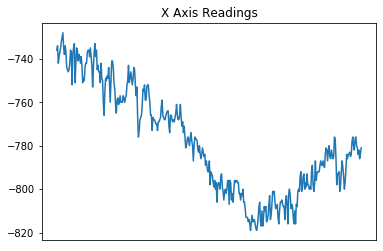

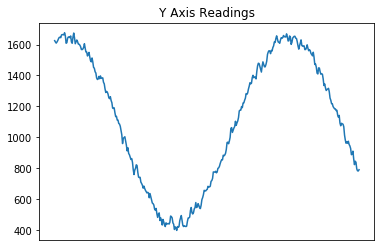

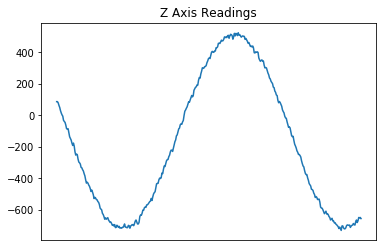

In [10]:
rand_start = random.randint(0, 650000)
df_part = data_df[rand_start: rand_start+400]
print('Graphs for 400 Readings')
plt.plot(df_part['Time'], df_part['X'])
plt.xticks([])
plt.title('X Axis Readings')
plt.show()

plt.plot(df_part['Time'], df_part['Y'])
plt.xticks([])
plt.title('Y Axis Readings')
plt.show()

plt.plot(df_part['Time'], df_part['Z'])
plt.xticks([])
plt.title('Z Axis Readings')
plt.show()

In [14]:
int('0100001101000001100110110001011111001110010100111101011000100111010101100010011110101111100100001001000110011101110011111001100100011001110111001000110010001101100010011101010010001100111111110100111111100111100100011001111100001001111111010100111011100111111100010011111110101001111100110011111111010011111000010011101110011101110010001100111111110100111110000100100111111001111111011100100111111001001111110011111000010011111000110011111000010011111110010100100111101001001110011110010010001100100111011100100111011100111101110100111101110100111100011001001110101001001000110010010001100111100011001111000110011110111010011110001100100111011100111100011001111011001010011110001100111101100010010010000100100111001111001001110101001001000010010010001100100111010', 2)

12746164589062952870982769233386913477817926023523623223540386838358220628672661651969741259020611321649623928942294939996160139210049120563437629932887981377355233519296111456746886251098529723172294506438121906081501523296721210

In [13]:
# this is from rosetta codes implementation of run length encoding
# http://rosettacode.org/wiki/Run-length_encoding#Python
def rle_encode(input_string):
    count = 1
    prev = ''
    lst = []
    for character in input_string:
        if character != prev:
            if prev:
                entry = (prev,count)
                lst.append(entry)
                #print lst
            count = 1
            prev = character
        else:
            count += 1
    else:
        try:
            entry = (character,count)
            lst.append(entry)
            return (lst, 0)
        except Exception as e:
            print("Exception encountered {e}".format(e=e)) 
            return (e, 1)
        
def rle_decode(lst):
    q = ""
    for character, count in lst:
        q += character * count
    return q
 
#Method call
value = rle_encode("aaaaahhhhhhmmmmmmmuiiiiiiiaaaaaa")
if value[1] == 0:
    print("Encoded value is {}".format(value[0]))
    rle_decode(value[0])
rle_decode(value[0])

huffman_encoded = '0100001101000001100110110001011111001110010100111101011000100111010101100010011110101111100100001001000110011101110011111001100100011001110111001000110010001101100010011101010010001100111111110100111111100111100100011001111100001001111111010100111011100111111100010011111110101001111100110011111111010011111000010011101110011101110010001100111111110100111110000100100111111001111111011100100111111001001111110011111000010011111000110011111000010011111110010100100111101001001110011110010010001100100111011100100111011100111101110100111101110100111100011001001110101001001000110010010001100111100011001111000110011110111010011110001100100111011100111100011001111011001010011110001100111101100010010010000100100111001111001001110101001001000010010010001100100111010'
value = rle_encode(huffman_encoded)
# print(value)
print(rle_decode(value[0]) == huffman_encoded)

Encoded value is [('a', 5), ('h', 6), ('m', 7), ('u', 1), ('i', 7), ('a', 6)]
True


In [50]:
# this is from https://stackabuse.com/run-length-encoding/
# RUN LENGTH ENCODING

def rle_encode(data):
    encoding = ''
    prev_char = ''
    count = 1

    if not data: return ''

    for char in data:
        # If the prev and current characters
        # don't match...
        if char != prev_char:
            # ...then add the count and character
            # to our encoding
            if prev_char:
                encoding += str(count) + prev_char
            count = 1
            prev_char = char
        else:
            # Or increment our counter
            # if the characters do match
            count += 1
    else:
        # Finish off the encoding
        encoding += str(count) + prev_char
        return encoding
    
encoded_val = rle_encode(huffman_encoded)

def rle_decode(data):
    decode = ''
    count = 1
    for char in data:
#         print('char', char)
        # If the character is numerical...
        if int(char) > 1:
            # ...append it to our count
            count += int(char)
        else:
            # Otherwise we've seen a non-numerical
            # character and need to expand it for
            # the decoding
#             print('count', count)
            decode += char * int(count)
            count = 1
    return decode

decoded_val = rle_decode(encoded_val)

print(sys.getsizeof(encoded_val), encoded_val)
print(sys.getsizeof(decoded_val))
# print(decoded_val)
# print('here')

715 101140211011502120211021301110512031201110112041101110213011203110111011102130112041101110512011401120113021203110312051202120113021203110312011302120113021102130112031101110112011302120811011207120412011302120514011207110111011203110312071301120711011101120512021208110112051401120311031203110312011302120811011205140112011206120711031201120612011206120514011205130212051401120712011101120112041101120112031204120112011302120112031103120112031103120411031101120411031101120413021201120311011101120112011302120112011302120413021204130212041103110112041302120112031103120413021204110212011101120413021204110213011201120114011201120312041201120311011101120112011401120112011302120112031101110
1133


In [15]:
start = random.randint(0, 650000)
num_of_readings = 20
initial = x_values[start]
full_values = x_values[start: start+num_of_readings]
full_joined = ','.join(map(str, full_values))
new = []
for i in range(start, start+num_of_readings):
    new.append(x_values[i]-initial)

lst_joined = ','.join(map(str, new))
final_str = str(initial)+':'+lst_joined
# print(new)
absx_values = [abs(x) for x in new]
print('Max x value:', max(absx_values))



initial = y_values[start]
full_values = y_values[start: start+num_of_readings]
full_joined = ','.join(map(str, full_values))
new = []
for i in range(start, start+num_of_readings):
    new.append(y_values[i]-initial)

lst_joined = ','.join(map(str, new))
final_str = str(initial)+':'+lst_joined
# print(new)
absy_values = [abs(x) for x in new]
print('Max y value:', max(absy_values))



initial = z_values[start]
full_values = z_values[start: start+num_of_readings]
full_joined = ','.join(map(str, full_values))
new = []
for i in range(start, start+num_of_readings):
    new.append(z_values[i]-initial)

lst_joined = ','.join(map(str, new))
final_str = str(initial)+':'+lst_joined
# print(new)
absz_values = [abs(x) for x in new]
print('Max z value:', max(absz_values))

def bits_required(list_of_abs):
    if max(list_of_abs) < 2:
        return 1
    if max(list_of_abs) < 4:
        return 2
    if max(list_of_abs) < 8:
        return 3
    if max(list_of_abs) < 16:
        return 4
    if max(list_of_abs) < 32:
        return 5
    if max(list_of_abs) < 64:
        return 6
    if max(list_of_abs) < 128:
        return 7
    if max(list_of_abs) < 256:
        return 8
    if max(list_of_abs) < 512:
        return 9
    if max(list_of_abs) < 1024:
        return 10
    if max(list_of_abs) < 2048:
        return 11
    
print('Bits required for x:', bits_required(absx_values))
print('Bits required for y:', bits_required(absy_values))
print('Bits required for z:', bits_required(absz_values))

Max x value: 69
Max y value: 134
Max z value: 139
Bits required for x: 7
Bits required for y: 8
Bits required for z: 8


In [16]:
x_bits = []
y_bits = []
z_bits = []

for i in range(10000):
    start = random.randint(0, 650000)
    num_of_readings = 70
    initial = x_values[start]
    full_values = x_values[start: start+num_of_readings]
    full_joined = ','.join(map(str, full_values))
    new = []
    for i in range(start, start+num_of_readings):
        new.append(x_values[i]-initial)

    lst_joined = ','.join(map(str, new))
    final_str = str(initial)+':'+lst_joined
    # print(new)
    absx_values = [abs(x) for x in new]
    # print('Max x value:', max(absx_values))



    initial = y_values[start]
    full_values = y_values[start: start+num_of_readings]
    full_joined = ','.join(map(str, full_values))
    new = []
    for i in range(start, start+num_of_readings):
        new.append(y_values[i]-initial)

    lst_joined = ','.join(map(str, new))
    final_str = str(initial)+':'+lst_joined
    # print(new)
    absy_values = [abs(x) for x in new]
    # print('Max y value:', max(absy_values))



    initial = z_values[start]
    full_values = z_values[start: start+num_of_readings]
    full_joined = ','.join(map(str, full_values))
    new = []
    for i in range(start, start+num_of_readings):
        new.append(z_values[i]-initial)

    lst_joined = ','.join(map(str, new))
    final_str = str(initial)+':'+lst_joined
    # print(new)
    absz_values = [abs(x) for x in new]
    # print('Max z value:', max(absz_values))

    x_bits.append(bits_required(absx_values))
    y_bits.append(bits_required(absy_values))
    z_bits.append(bits_required(absz_values))

In [14]:
# x_bits

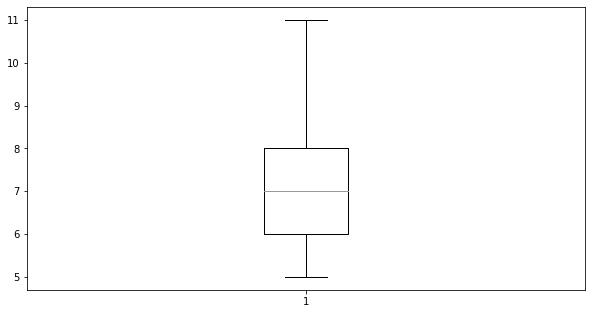

In [321]:
plt.boxplot(x_bits)
# plt.boxplot(y_bits)
# plt.boxplot(z_bits)
plt.show()

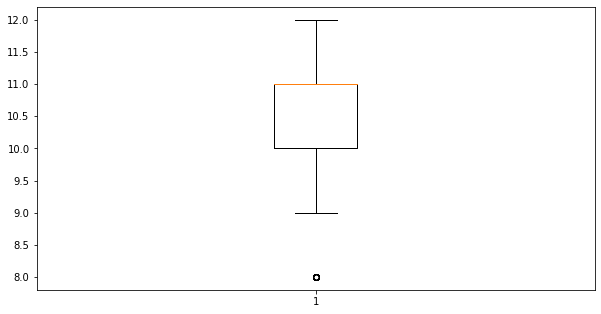

In [322]:
plt.boxplot(y_bits)
plt.show()

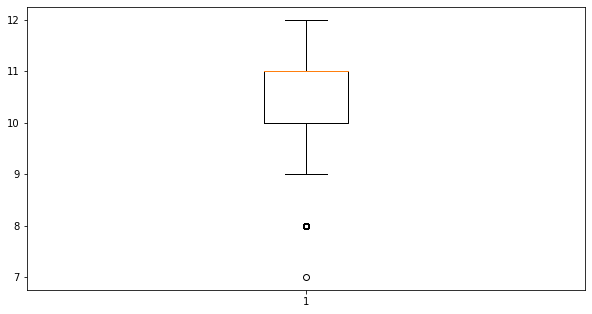

In [323]:
plt.boxplot(z_bits)
plt.show()

In [17]:
bits_df = pd.DataFrame(data=list(zip(x_bits, y_bits, z_bits)), columns=['x_bits', 'y_bits', 'z_bits'])
bits_df

,x_bits,y_bits,z_bits
0,5,9,10
1,6,10,10
2,5,8,10
3,6,10,10
4,7,9,10
...,...,...,...
9995,5,10,8
9996,7,10,10
9997,6,10,10
9998,4,10,8


In [18]:
bits_df['total_bits'] = bits_df['x_bits'] + bits_df['y_bits'] + bits_df['z_bits']
bits_df

,x_bits,y_bits,z_bits,total_bits
0,5,9,10,24
1,6,10,10,26
2,5,8,10,23
3,6,10,10,26
4,7,9,10,26
...,...,...,...,...
9995,5,10,8,23
9996,7,10,10,27
9997,6,10,10,26
9998,4,10,8,22


In [19]:
bits_df['50_samples'] = 42 + bits_df['total_bits']*49
bits_df['100_samples'] = 42 + bits_df['total_bits']*99
bits_df['150_samples'] = 42 + bits_df['total_bits']*149
bits_df['200_samples'] = 42 + bits_df['total_bits']*199
bits_df['250_samples'] = 42 + bits_df['total_bits']*249
bits_df['300_samples'] = 42 + bits_df['total_bits']*299
bits_df['350_samples'] = 42 + bits_df['total_bits']*349
bits_df

,x_bits,y_bits,z_bits,total_bits,50_samples,100_samples,150_samples,200_samples,250_samples,300_samples,350_samples
0,5,9,10,24,1218,2418,3618,4818,6018,7218,8418
1,6,10,10,26,1316,2616,3916,5216,6516,7816,9116
2,5,8,10,23,1169,2319,3469,4619,5769,6919,8069
3,6,10,10,26,1316,2616,3916,5216,6516,7816,9116
4,7,9,10,26,1316,2616,3916,5216,6516,7816,9116
...,...,...,...,...,...,...,...,...,...,...,...
9995,5,10,8,23,1169,2319,3469,4619,5769,6919,8069
9996,7,10,10,27,1365,2715,4065,5415,6765,8115,9465
9997,6,10,10,26,1316,2616,3916,5216,6516,7816,9116
9998,4,10,8,22,1120,2220,3320,4420,5520,6620,7720


In [20]:
# what about sign? does it require an extra bit?
# uc = uncompressed
bits_df['50_uc'] = 42*50
bits_df['100_uc'] = 42*100
bits_df['150_uc'] = 42*150
bits_df['200_uc'] = 42*200
bits_df['250_uc'] = 42*250
bits_df['300_uc'] = 42*300
bits_df['350_uc'] = 42*350
bits_df

,x_bits,y_bits,z_bits,total_bits,50_samples,100_samples,150_samples,200_samples,250_samples,300_samples,350_samples,50_uc,100_uc,150_uc,200_uc,250_uc,300_uc,350_uc
0,5,9,10,24,1218,2418,3618,4818,6018,7218,8418,2100,4200,6300,8400,10500,12600,14700
1,6,10,10,26,1316,2616,3916,5216,6516,7816,9116,2100,4200,6300,8400,10500,12600,14700
2,5,8,10,23,1169,2319,3469,4619,5769,6919,8069,2100,4200,6300,8400,10500,12600,14700
3,6,10,10,26,1316,2616,3916,5216,6516,7816,9116,2100,4200,6300,8400,10500,12600,14700
4,7,9,10,26,1316,2616,3916,5216,6516,7816,9116,2100,4200,6300,8400,10500,12600,14700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,5,10,8,23,1169,2319,3469,4619,5769,6919,8069,2100,4200,6300,8400,10500,12600,14700
9996,7,10,10,27,1365,2715,4065,5415,6765,8115,9465,2100,4200,6300,8400,10500,12600,14700
9997,6,10,10,26,1316,2616,3916,5216,6516,7816,9116,2100,4200,6300,8400,10500,12600,14700
9998,4,10,8,22,1120,2220,3320,4420,5520,6620,7720,2100,4200,6300,8400,10500,12600,14700


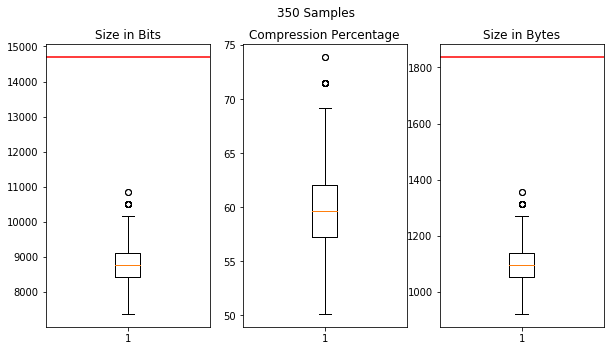

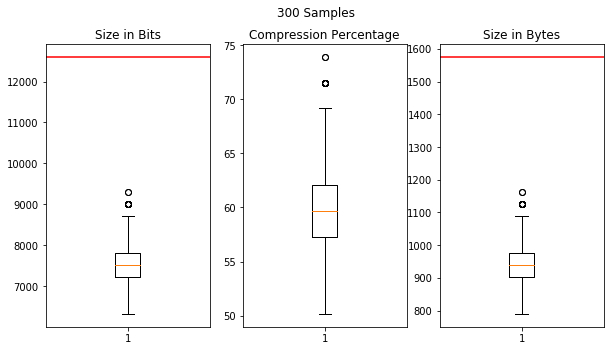

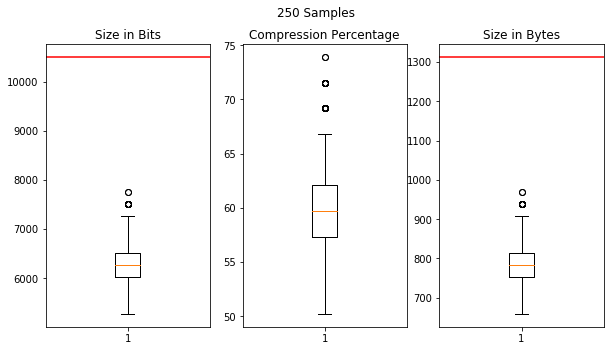

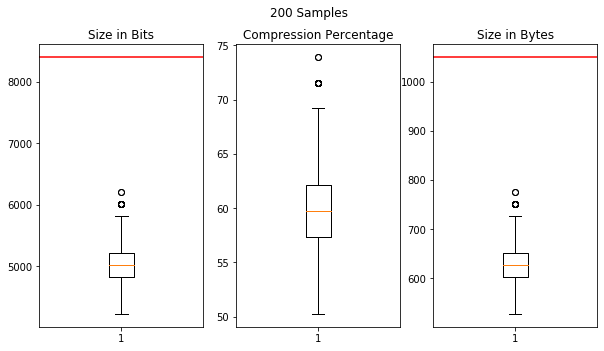

In [20]:
from pylab import rcParams
import matplotlib.gridspec as gridspec
rcParams['figure.figsize'] = 10, 5.2 # width, height (both in inches)
gs = gridspec.GridSpec(1, 3) # 1 row, 3 columns

fig = plt.figure()
ax = fig.add_subplot(gs[0, 0])
ax.boxplot(bits_df['350_samples'])
ax.axhline(y=bits_df['350_uc'][0], xmin=0, xmax=1, color='r')
ax.title.set_text('Size in Bits')

ax2 = fig.add_subplot(gs[0, 1])
ax2.boxplot(bits_df['350_samples']*100/bits_df['350_uc'])
ax2.title.set_text('Compression Percentage')

ax3 = fig.add_subplot(gs[0, 2])
ax3.boxplot(bits_df['350_samples']/8)
ax3.axhline(y=bits_df['350_uc'][0]/8, xmin=0, xmax=1, color='r')
ax3.title.set_text('Size in Bytes')

plt.suptitle('350 Samples')
plt.show()
#----------------------------------------------------------

fig = plt.figure()
ax = fig.add_subplot(gs[0, 0])
ax.boxplot(bits_df['300_samples'])
ax.axhline(y=bits_df['300_uc'][0], xmin=0, xmax=1, color='r')
ax.title.set_text('Size in Bits')

ax2 = fig.add_subplot(gs[0, 1])
ax2.boxplot(bits_df['300_samples']*100/bits_df['300_uc'])
ax2.title.set_text('Compression Percentage')

ax3 = fig.add_subplot(gs[0, 2])
ax3.boxplot(bits_df['300_samples']/8)
ax3.axhline(y=bits_df['300_uc'][0]/8, xmin=0, xmax=1, color='r')
ax3.title.set_text('Size in Bytes')

plt.suptitle('300 Samples')
plt.show()
#----------------------------------------------------------

fig = plt.figure()
ax = fig.add_subplot(gs[0, 0])
ax.boxplot(bits_df['250_samples'])
ax.axhline(y=bits_df['250_uc'][0], xmin=0, xmax=1, color='r')
ax.title.set_text('Size in Bits')

ax2 = fig.add_subplot(gs[0, 1])
ax2.boxplot(bits_df['250_samples']*100/bits_df['250_uc'])
ax2.title.set_text('Compression Percentage')

ax3 = fig.add_subplot(gs[0, 2])
ax3.boxplot(bits_df['250_samples']/8)
ax3.axhline(y=bits_df['250_uc'][0]/8, xmin=0, xmax=1, color='r')
ax3.title.set_text('Size in Bytes')

plt.suptitle('250 Samples')
plt.show()
#----------------------------------------------------------

fig = plt.figure()
ax = fig.add_subplot(gs[0, 0]) # row, column
ax.boxplot(bits_df['200_samples'])
ax.axhline(y=bits_df['200_uc'][0], xmin=0, xmax=1, color='r')
ax.title.set_text('Size in Bits')

ax2 = fig.add_subplot(gs[0, 1])
ax2.boxplot(bits_df['200_samples']*100/bits_df['200_uc'])
ax2.title.set_text('Compression Percentage')

ax3 = fig.add_subplot(gs[0, 2])
ax3.boxplot(bits_df['200_samples']/8)
ax3.axhline(y=bits_df['200_uc'][0]/8, xmin=0, xmax=1, color='r')
ax3.title.set_text('Size in Bytes')

plt.suptitle('200 Samples')
plt.show()

In [21]:
def huff_code(how_many_readings, values, start_value):
    initial = values[start_value]
    diff_string = []
    for i in range(start_value, start_value + int(how_many_readings)):
        diff_string.append(values[i] - initial)
    
    lst_joined = ','.join(map(str, diff_string))
    str_with_initial = str(initial) + ':' + lst_joined # final string with initial and differences
    
    codes = {}
    fre = frequency(str_with_initial)
    tuples_for_tree = sortFreq(fre)
    tree = buildTree(tuples_for_tree)
    trimmed_tree = trimTree(tree)
    assignCodes(trimmed_tree)
    encoded = encode_str(str_with_initial)
    return encoded

In [39]:
# all huffman in BITS as of 16/11/2019
huff_x_50 = []
huff_y_50 = []
huff_z_50 = []

huff_x_100 = []
huff_y_100 = []
huff_z_100 = []

huff_x_150 = []
huff_y_150 = []
huff_z_150 = []

huff_x_200 = []
huff_y_200 = []
huff_z_200 = []

huff_x_250 = []
huff_y_250 = []
huff_z_250 = []

huff_x_300 = []
huff_y_300 = []
huff_z_300 = []

huff_x_350 = []
huff_y_350 = []
huff_z_350 = []

for i in range(10000):
    start = random.randint(0, 650000)
#     num_of_readings = 70
#     for i in range(50, 351, 50):
    huff_x_50.append(len(huff_code(50, x_values, start)))
    huff_y_50.append(len(huff_code(50, y_values, start)))
    huff_z_50.append(len(huff_code(50, z_values, start)))
    
    huff_x_100.append(len(huff_code(100, x_values, start)))
    huff_y_100.append(len(huff_code(100, y_values, start)))
    huff_z_100.append(len(huff_code(100, z_values, start)))
    
    huff_x_150.append(len(huff_code(150, x_values, start)))
    huff_y_150.append(len(huff_code(150, y_values, start)))
    huff_z_150.append(len(huff_code(150, z_values, start)))
    
    huff_x_200.append(len(huff_code(200, x_values, start)))
    huff_y_200.append(len(huff_code(200, y_values, start)))
    huff_z_200.append(len(huff_code(200, z_values, start)))
    
    huff_x_250.append(len(huff_code(250, x_values, start)))
    huff_y_250.append(len(huff_code(250, y_values, start)))
    huff_z_250.append(len(huff_code(250, z_values, start)))
    
    huff_x_300.append(len(huff_code(300, x_values, start)))
    huff_y_300.append(len(huff_code(300, y_values, start)))
    huff_z_300.append(len(huff_code(300, z_values, start)))
    
    huff_x_350.append(len(huff_code(350, x_values, start)))
    huff_y_350.append(len(huff_code(350, y_values, start)))
    huff_z_350.append(len(huff_code(350, z_values, start)))
    

In [40]:
huff_df = pd.DataFrame(data=list(zip(huff_x_50, huff_y_50, huff_z_50,
                                    huff_x_100, huff_y_100, huff_z_100,
                                    huff_x_150, huff_y_150, huff_z_150,
                                    huff_x_200, huff_y_200, huff_z_200,
                                    huff_x_250, huff_y_250, huff_z_250,
                                    huff_x_300, huff_y_300, huff_z_300,
                                    huff_x_350, huff_y_350, huff_z_350)),
                      columns=['50x_com', '50y_com', '50z_com',
                              '100x_com', '100y_com', '100z_com',
                              '150x_com', '150y_com', '150z_com',
                              '200x_com', '200y_com', '200z_com',
                              '250x_com', '250y_com', '250z_com',
                              '300x_com', '300y_com', '300z_com',
                              '350x_com', '350y_com', '350z_com'])

huff_df['50_com'] = huff_df['50x_com'] + huff_df['50y_com'] + huff_df['50z_com']
huff_df['100_com'] = huff_df['100x_com'] + huff_df['100y_com'] + huff_df['100z_com']
huff_df['150_com'] = huff_df['150x_com'] + huff_df['150y_com'] + huff_df['150z_com']
huff_df['150_com'] = huff_df['200x_com'] + huff_df['200y_com'] + huff_df['200z_com']
huff_df['250_com'] = huff_df['250x_com'] + huff_df['250y_com'] + huff_df['250z_com']
huff_df['300_com'] = huff_df['300x_com'] + huff_df['300y_com'] + huff_df['300z_com']
huff_df['350_com'] = huff_df['350x_com'] + huff_df['350y_com'] + huff_df['350z_com']

huff_df['50_uc'] = 42*50
huff_df['100_uc'] = 42*100
huff_df['150_uc'] = 42*150
huff_df['200_uc'] = 42*200
huff_df['250_uc'] = 42*250
huff_df['300_uc'] = 42*300
huff_df['350_uc'] = 42*350

huff_df

,50x_com,50y_com,50z_com,100x_com,100y_com,100z_com,150x_com,150y_com,150z_com,200x_com,...,250_com,300_com,350_com,50_uc,100_uc,150_uc,200_uc,250_uc,300_uc,350_uc
0,534,811,577,1162,1684,1286,1884,2550,2104,2613,...,10974,13165,15338,2100,4200,6300,8400,10500,12600,14700
1,454,625,527,811,1305,1388,1193,1972,2338,1630,...,9814,11643,13351,2100,4200,6300,8400,10500,12600,14700
2,573,710,828,1262,1624,1680,2034,2646,2479,2844,...,12075,14444,16975,2100,4200,6300,8400,10500,12600,14700
3,584,633,770,1104,1272,1651,1750,2050,2502,2381,...,11016,13163,15349,2100,4200,6300,8400,10500,12600,14700
4,568,643,748,1187,1292,1684,1793,2100,2685,2432,...,11453,13523,15724,2100,4200,6300,8400,10500,12600,14700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,588,804,589,1248,1650,1307,1809,2514,1959,2378,...,10738,12914,15228,2100,4200,6300,8400,10500,12600,14700
9996,458,635,514,942,1310,1371,1405,1965,2316,1858,...,10195,12389,14316,2100,4200,6300,8400,10500,12600,14700
9997,504,807,818,1118,1768,1644,1703,2788,2357,2318,...,11448,13330,15729,2100,4200,6300,8400,10500,12600,14700
9998,464,814,623,1044,1647,1385,1684,2359,2214,2335,...,10650,12887,15085,2100,4200,6300,8400,10500,12600,14700


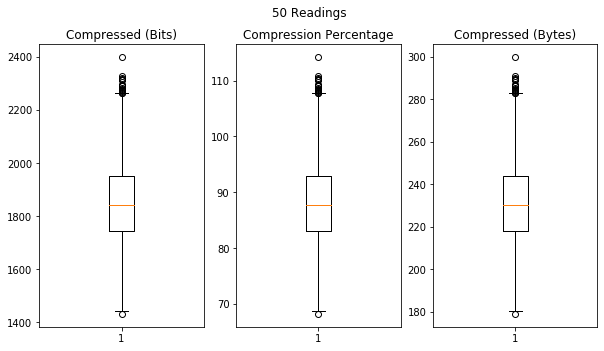

In [43]:
from pylab import rcParams
import matplotlib.gridspec as gridspec
rcParams['figure.figsize'] = 10, 5.2 # width, height (both in inches)
gs = gridspec.GridSpec(1, 3) # 1 row, 3 columns

fig = plt.figure()
ax = fig.add_subplot(gs[0, 0])
ax.boxplot(huff_df['50_com'])
# ax.axhline(y=bits_df['350_uc'][0], xmin=0, xmax=1, color='r')
ax.title.set_text('Compressed (Bits)')

ax2 = fig.add_subplot(gs[0, 1])
ax2.boxplot(huff_df['50_com']*100/huff_df['50_uc'])
ax2.title.set_text('Compression Percentage')

ax3 = fig.add_subplot(gs[0, 2])
ax3.boxplot(huff_df['50_com']/8)
# ax3.axhline(y=bits_df['350_uc'][0]/8, xmin=0, xmax=1, color='r')
ax3.title.set_text('Compressed (Bytes)')

plt.suptitle('50 Readings')
plt.show()

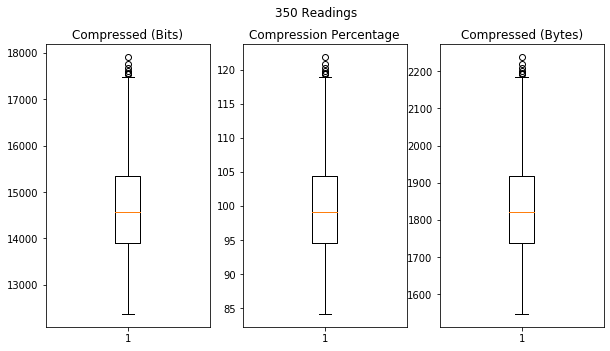

In [53]:
from pylab import rcParams
import matplotlib.gridspec as gridspec
rcParams['figure.figsize'] = 10, 5.2 # width, height (both in inches)
gs = gridspec.GridSpec(1, 3) # 1 row, 3 columns

fig = plt.figure()
ax = fig.add_subplot(gs[0, 0])
ax.boxplot(huff_df['350_com'])
# ax.axhline(y=bits_df['350_uc'][0], xmin=0, xmax=1, color='r')
ax.title.set_text('Compressed (Bits)')

ax2 = fig.add_subplot(gs[0, 1])
ax2.boxplot(huff_df['350_com']*100/huff_df['350_uc'])
ax2.title.set_text('Compression Percentage')

ax3 = fig.add_subplot(gs[0, 2])
ax3.boxplot(huff_df['350_com']/8)
# ax3.axhline(y=bits_df['350_uc'][0]/8, xmin=0, xmax=1, color='r')
ax3.title.set_text('Compressed (Bytes)')

plt.suptitle('350 Readings')
plt.show()

In [48]:
pd.set_option('display.max_columns', 500)
print(huff_df['50_com'], huff_df['50_uc'])
huff_df.describe()

0       1922
1       1606
2       2111
3       1987
4       1959
        ... 
9995    1981
9996    1607
9997    2129
9998    1901
9999    2022
Name: 50_com, Length: 10000, dtype: int64 0       2100
1       2100
2       2100
3       2100
4       2100
        ... 
9995    2100
9996    2100
9997    2100
9998    2100
9999    2100
Name: 50_uc, Length: 10000, dtype: int64


,50x_com,50y_com,50z_com,100x_com,100y_com,100z_com,150x_com,150y_com,150z_com,200x_com,200y_com,200z_com,250x_com,250y_com,250z_com,300x_com,300y_com,300z_com,350x_com,350y_com,350z_com,50_com,100_com,150_com,250_com,300_com,350_com,50_uc,100_uc,150_uc,200_uc,250_uc,300_uc,350_uc
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
mean,473.962500,687.905500,687.035900,1001.808400,1463.971700,1465.113100,1563.620500,2291.450700,2293.448100,2143.593100,3120.745300,3123.29010,2734.10860,3906.049000,3910.401100,3331.045600,4606.895200,4610.854900,3934.480400,5350.243000,5355.83240,1848.903900,3930.893200,8387.628500,10550.558700,12548.795700,14640.555800,2100.0,4200.0,6300.0,8400.0,10500.0,12600.0,14700.0
std,85.896344,98.648173,100.419608,188.550137,179.570149,180.362785,299.816428,251.470007,249.550414,416.056265,300.563593,298.08832,536.07964,327.399433,323.264782,658.960872,338.660919,333.635904,783.887402,384.977955,382.34724,149.478941,297.861827,592.352001,722.820668,869.134797,1015.781677,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,298.000000,463.000000,442.000000,630.000000,1081.000000,1025.000000,964.000000,1763.000000,1697.000000,1282.000000,2407.000000,2408.00000,1651.00000,2999.000000,2950.000000,1986.000000,3595.000000,3656.000000,2354.000000,4245.000000,4352.00000,1432.000000,3194.000000,6769.000000,8765.000000,10598.000000,12373.000000,2100.0,4200.0,6300.0,8400.0,10500.0,12600.0,14700.0
25%,404.000000,615.000000,613.750000,857.000000,1307.000000,1307.000000,1331.000000,2091.000000,2096.000000,1819.000000,2880.000000,2887.00000,2307.00000,3655.000000,3665.000000,2796.000000,4361.000000,4379.000000,3296.000000,5078.000000,5096.75000,1744.750000,3723.000000,7977.000000,10039.000000,11908.000000,13895.000000,2100.0,4200.0,6300.0,8400.0,10500.0,12600.0,14700.0
50%,464.000000,649.000000,652.000000,983.000000,1399.000000,1406.000000,1538.000000,2225.500000,2230.000000,2109.000000,3056.000000,3061.00000,2684.00000,3847.000000,3851.000000,3265.000000,4581.000000,4581.000000,3864.000000,5338.000000,5340.00000,1841.000000,3918.000000,8345.000000,10489.500000,12465.000000,14559.000000,2100.0,4200.0,6300.0,8400.0,10500.0,12600.0,14700.0
75%,538.000000,795.000000,797.000000,1133.000000,1650.000000,1651.000000,1758.000000,2508.000000,2502.000000,2397.000000,3327.250000,3321.25000,3058.00000,4143.000000,4145.000000,3727.000000,4848.000000,4858.000000,4404.250000,5592.250000,5602.00000,1952.000000,4131.000000,8779.000000,11034.000000,13133.250000,15338.000000,2100.0,4200.0,6300.0,8400.0,10500.0,12600.0,14700.0
max,786.000000,949.000000,928.000000,1639.000000,1986.000000,1941.000000,2493.000000,2940.000000,2930.000000,3356.000000,3967.000000,3935.00000,4198.00000,4840.000000,4847.000000,5050.000000,5715.000000,5722.000000,5882.000000,6635.000000,6702.00000,2399.000000,5017.000000,10179.000000,12873.000000,15348.000000,17910.000000,2100.0,4200.0,6300.0,8400.0,10500.0,12600.0,14700.0


# Differences from previous value not initial trial

# WHAT TO DO ABOUT SIGN CHANGE??

In [21]:
start = random.randint(0, 650000)
num_of_readings = 70
initial = x_values[start]
full_values = x_values[start: start+num_of_readings]
full_joined = ','.join(map(str, full_values))
vals = []
for i in range(start, start+num_of_readings):
    vals.append(x_values[i])

diff = []
for i in range(len(vals)):
    if i == 0:
        diff.append(vals[i] - initial)
    else:
        diff.append(vals[i] - vals[i-1])

lst_joined = ','.join(map(str, diff))
final_str = str(initial)+':'+lst_joined
print(diff)
# print(final_str)
absx_values = [abs(x) for x in diff]
# print('Max x value:', max(absx_values))



initial = y_values[start]
full_values = y_values[start: start+num_of_readings]
full_joined = ','.join(map(str, full_values))
vals = []
for i in range(start, start+num_of_readings):
    vals.append(y_values[i])

diff = []
for i in range(len(vals)):
    if i == 0:
        diff.append(vals[i] - initial)
    else:
        diff.append(vals[i] - vals[i-1])

lst_joined = ','.join(map(str, diff))
final_str = str(initial)+':'+lst_joined
print(diff)
absy_values = [abs(x) for x in diff]



initial = z_values[start]
full_values = z_values[start: start+num_of_readings]
full_joined = ','.join(map(str, full_values))
vals = []
for i in range(start, start+num_of_readings):
    vals.append(z_values[i])

diff = []
for i in range(len(vals)):
    if i == 0:
        diff.append(vals[i] - initial)
    else:
        diff.append(vals[i] - vals[i-1])

lst_joined = ','.join(map(str, diff))
final_str = str(initial)+':'+lst_joined
print(diff)
absz_values = [abs(x) for x in diff]

# THIS ONE IS FOR THE SIGN AS WELL
def bits_required_sign(list_of_abs):
    if max(list_of_abs) < 2:
        return 1+1
    if max(list_of_abs) < 4:
        return 2+1
    if max(list_of_abs) < 8:
        return 3+1
    if max(list_of_abs) < 16:
        return 4+1
    if max(list_of_abs) < 32:
        return 5+1
    if max(list_of_abs) < 64:
        return 6+1
    if max(list_of_abs) < 128:
        return 7+1
    if max(list_of_abs) < 256:
        return 8+1
    if max(list_of_abs) < 512:
        return 9+1
    if max(list_of_abs) < 1024:
        return 10+1
    if max(list_of_abs) < 2048:
        return 11+1
    
    
codes={}
qwe = frequency(final_str)
tuples_for_tree = sortFreq(qwe)
tree = buildTree(tuples_for_tree)
trimmed = trimTree(tree)
assignCodes(trimmed)
encoded = encode_str(final_str)
# print('Length of Huffman string:', len(encoded))
print('Bits required for x:', bits_required_sign(absx_values))
print('Bits required for y:', bits_required_sign(absy_values))
print('Bits required for z:', bits_required_sign(absz_values))

[0, 7, -2, -1, -1, 4, -6, 1, -3, 1, 3, -2, 1, 5, 1, -3, 4, 4, -6, -11, 5, -2, 4, -1, -2, 0, 0, 4, -1, -5, 0, 1, -1, -1, 5, -3, -3, -6, -4, 4, 0, -10, -1, 8, 0, 2, -5, 3, 4, -6, -3, 1, 1, 4, -2, 0, -8, -5, 5, 3, -1, 0, -6, 5, 4, 1, -11, -4, 1, 9]
[0, -7, -33, -43, -20, -10, -11, -31, -15, 10, -21, -48, -51, -18, -13, 19, -13, -42, -20, 2, 4, 7, -33, -35, -13, -25, -8, -30, -35, 31, -14, -31, 15, -25, -36, -2, -1, -8, -25, 6, -16, 1, -1, -9, -22, -29, 14, 13, -43, -53, 0, 12, 2, 23, -15, -11, -22, 10, 1, -17, -22, -18, 25, 4, -18, 23, 18, -12, 6, -10]
[0, -2, 17, 3, -5, 6, -6, 13, -4, 2, 13, 9, 14, 7, 8, -12, 7, 22, -2, -4, -2, -7, 22, 15, 5, 18, 2, 19, 19, -8, 16, 15, 3, 20, 19, 2, 12, 12, 22, 7, 15, 5, 16, 22, 18, 21, -2, 11, 39, 26, 8, 13, 11, 7, 23, 21, 24, 14, 20, 15, 25, 19, 0, 19, 35, 4, 12, 25, 15, 16]
Bits required for x: 5
Bits required for y: 7
Bits required for z: 7


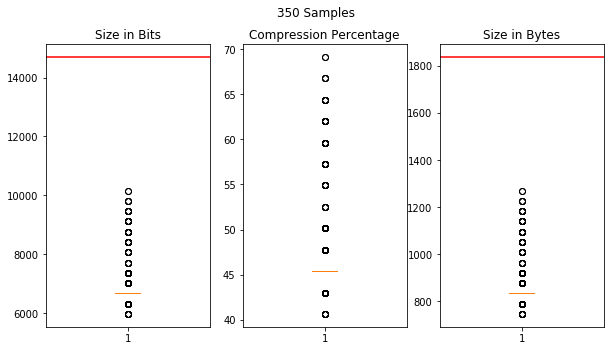

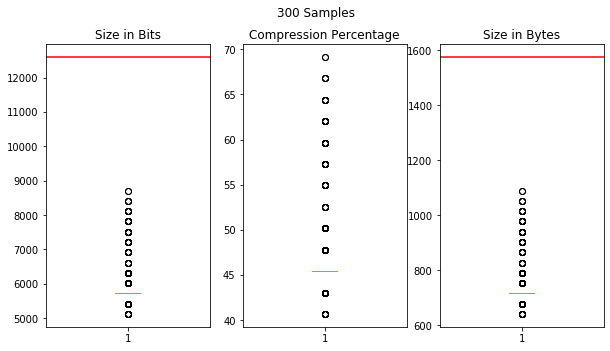

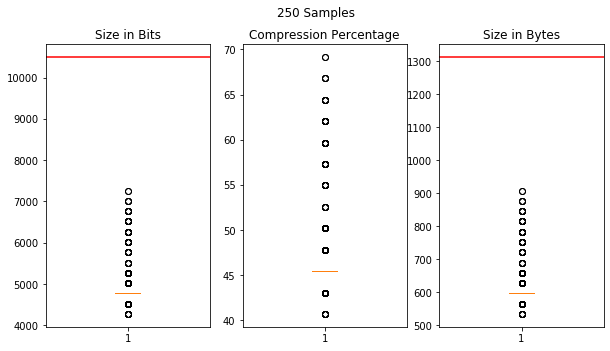

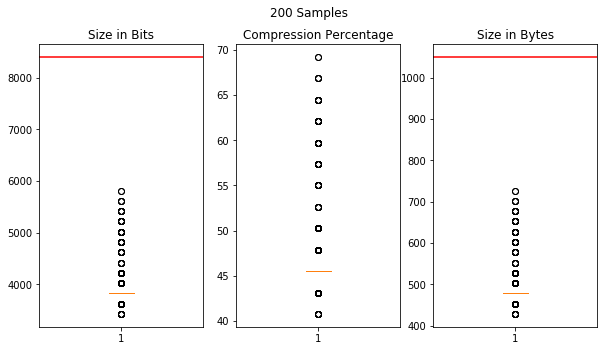

In [22]:
x_bits_d = []
y_bits_d = []
z_bits_d = []

for i in range(10000):
    start = random.randint(0, 650000)
    num_of_readings = 70
    initial = x_values[start]
    full_values = x_values[start: start+num_of_readings]
    full_joined = ','.join(map(str, full_values))
    vals = []
    for i in range(start, start+num_of_readings):
        vals.append(x_values[i])

    diff = []
    for i in range(len(vals)):
        if i == 0:
            diff.append(vals[i] - initial)
        else:
            diff.append(vals[i] - vals[i-1])

    lst_joined = ','.join(map(str, diff))
    final_str = str(initial)+':'+lst_joined
    absx_values = [abs(x) for x in diff]



    initial = y_values[start]
    full_values = y_values[start: start+num_of_readings]
    full_joined = ','.join(map(str, full_values))
    vals = []
    for i in range(start, start+num_of_readings):
        vals.append(y_values[i])

    diff = []
    for i in range(len(vals)):
        if i == 0:
            diff.append(vals[i] - initial)
        else:
            diff.append(vals[i] - vals[i-1])

    lst_joined = ','.join(map(str, diff))
    final_str = str(initial)+':'+lst_joined
    absy_values = [abs(x) for x in diff]



    initial = z_values[start]
    full_values = z_values[start: start+num_of_readings]
    full_joined = ','.join(map(str, full_values))
    vals = []
    for i in range(start, start+num_of_readings):
        vals.append(z_values[i])

    diff = []
    for i in range(len(vals)):
        if i == 0:
            diff.append(vals[i] - initial)
        else:
            diff.append(vals[i] - vals[i-1])

    lst_joined = ','.join(map(str, diff))
    final_str = str(initial)+':'+lst_joined
    absz_values = [abs(x) for x in diff]

    x_bits_d.append(bits_required_sign(absx_values))
    y_bits_d.append(bits_required_sign(absy_values))
    z_bits_d.append(bits_required_sign(absz_values))
    
    
bits_df_d = pd.DataFrame(data=list(zip(x_bits_d, y_bits_d, z_bits_d)), columns=['x_bits', 'y_bits', 'z_bits'])
bits_df_d['total_bits'] = bits_df_d['x_bits'] + bits_df_d['y_bits'] + bits_df_d['z_bits']
bits_df_d['50_samples'] = 42 + bits_df_d['total_bits']*49
bits_df_d['100_samples'] = 42 + bits_df_d['total_bits']*99
bits_df_d['150_samples'] = 42 + bits_df_d['total_bits']*149
bits_df_d['200_samples'] = 42 + bits_df_d['total_bits']*199
bits_df_d['250_samples'] = 42 + bits_df_d['total_bits']*249
bits_df_d['300_samples'] = 42 + bits_df_d['total_bits']*299
bits_df_d['350_samples'] = 42 + bits_df_d['total_bits']*349
# uc = uncompressed
bits_df_d['50_uc'] = 42*50
bits_df_d['100_uc'] = 42*100
bits_df_d['150_uc'] = 42*150
bits_df_d['200_uc'] = 42*200
bits_df_d['250_uc'] = 42*250
bits_df_d['300_uc'] = 42*300
bits_df_d['350_uc'] = 42*350


from pylab import rcParams
import matplotlib.gridspec as gridspec
rcParams['figure.figsize'] = 10, 5.2 # width, height (both in inches)
gs = gridspec.GridSpec(1, 3) # 1 row, 3 columns

fig = plt.figure()
ax = fig.add_subplot(gs[0, 0])
ax.boxplot(bits_df_d['350_samples'])
ax.axhline(y=bits_df_d['350_uc'][0], xmin=0, xmax=1, color='r')
ax.title.set_text('Size in Bits')

ax2 = fig.add_subplot(gs[0, 1])
ax2.boxplot(bits_df_d['350_samples']*100/bits_df_d['350_uc'])
ax2.title.set_text('Compression Percentage')

ax3 = fig.add_subplot(gs[0, 2])
ax3.boxplot(bits_df_d['350_samples']/8)
ax3.axhline(y=bits_df_d['350_uc'][0]/8, xmin=0, xmax=1, color='r')
ax3.title.set_text('Size in Bytes')

plt.suptitle('350 Samples')
plt.show()
#----------------------------------------------------------

fig = plt.figure()
ax = fig.add_subplot(gs[0, 0])
ax.boxplot(bits_df_d['300_samples'])
ax.axhline(y=bits_df_d['300_uc'][0], xmin=0, xmax=1, color='r')
ax.title.set_text('Size in Bits')

ax2 = fig.add_subplot(gs[0, 1])
ax2.boxplot(bits_df_d['300_samples']*100/bits_df_d['300_uc'])
ax2.title.set_text('Compression Percentage')

ax3 = fig.add_subplot(gs[0, 2])
ax3.boxplot(bits_df_d['300_samples']/8)
ax3.axhline(y=bits_df_d['300_uc'][0]/8, xmin=0, xmax=1, color='r')
ax3.title.set_text('Size in Bytes')

plt.suptitle('300 Samples')
plt.show()
#----------------------------------------------------------

fig = plt.figure()
ax = fig.add_subplot(gs[0, 0])
ax.boxplot(bits_df_d['250_samples'])
ax.axhline(y=bits_df_d['250_uc'][0], xmin=0, xmax=1, color='r')
ax.title.set_text('Size in Bits')

ax2 = fig.add_subplot(gs[0, 1])
ax2.boxplot(bits_df_d['250_samples']*100/bits_df_d['250_uc'])
ax2.title.set_text('Compression Percentage')

ax3 = fig.add_subplot(gs[0, 2])
ax3.boxplot(bits_df_d['250_samples']/8)
ax3.axhline(y=bits_df_d['250_uc'][0]/8, xmin=0, xmax=1, color='r')
ax3.title.set_text('Size in Bytes')

plt.suptitle('250 Samples')
plt.show()
#----------------------------------------------------------

fig = plt.figure()
ax = fig.add_subplot(gs[0, 0]) # row, column
ax.boxplot(bits_df_d['200_samples'])
ax.axhline(y=bits_df_d['200_uc'][0], xmin=0, xmax=1, color='r')
ax.title.set_text('Size in Bits')

ax2 = fig.add_subplot(gs[0, 1])
ax2.boxplot(bits_df_d['200_samples']*100/bits_df_d['200_uc'])
ax2.title.set_text('Compression Percentage')

ax3 = fig.add_subplot(gs[0, 2])
ax3.boxplot(bits_df_d['200_samples']/8)
ax3.axhline(y=bits_df_d['200_uc'][0]/8, xmin=0, xmax=1, color='r')
ax3.title.set_text('Size in Bytes')

plt.suptitle('200 Samples')
plt.show()

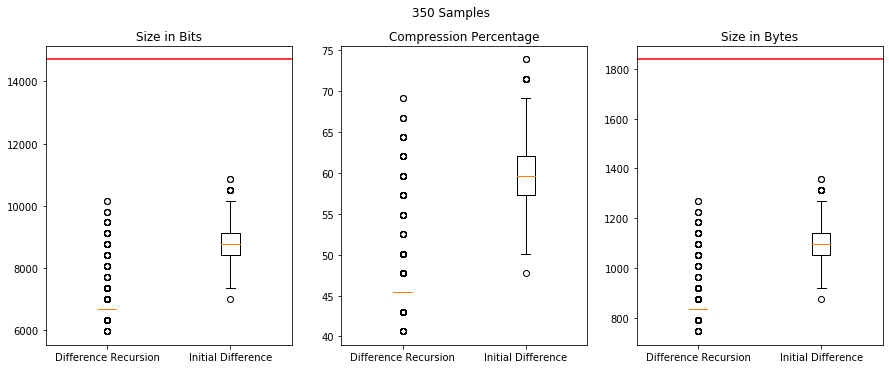

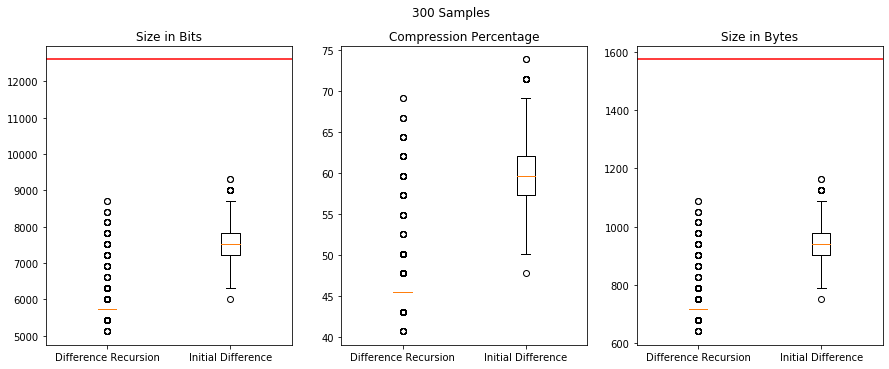

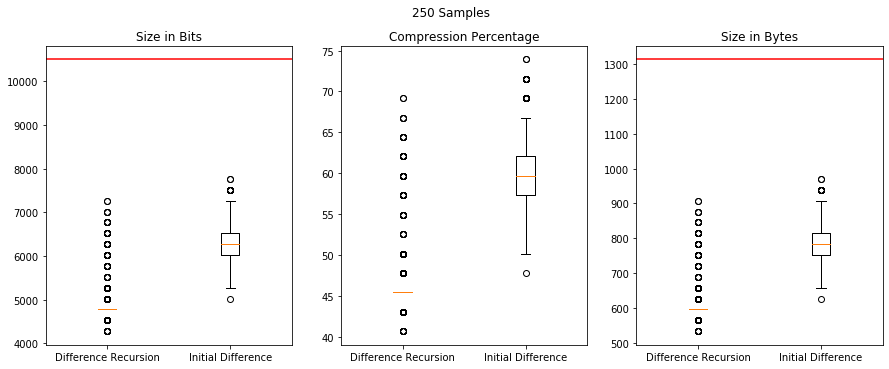

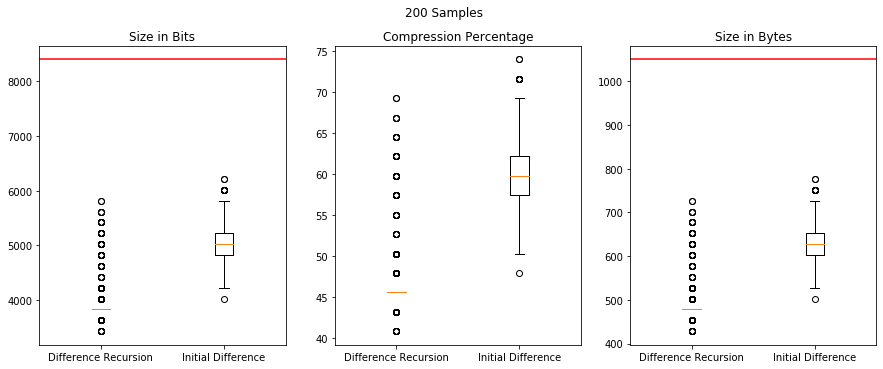

In [23]:
from pylab import rcParams
import matplotlib.gridspec as gridspec
rcParams['figure.figsize'] = 15, 5.5 # width, height (both in inches)
gs = gridspec.GridSpec(1, 3) # 1 row, 3 columns

fig = plt.figure()
ax = fig.add_subplot(gs[0, 0])
ax.boxplot([bits_df_d['350_samples'], bits_df['350_samples']])
ax.set_xticklabels(['Difference Recursion', 'Initial Difference'])
ax.axhline(y=bits_df_d['350_uc'][0], xmin=0, xmax=1, color='r')
ax.title.set_text('Size in Bits')

ax2 = fig.add_subplot(gs[0, 1])
ax2.boxplot([bits_df_d['350_samples']*100/bits_df_d['350_uc'],
            bits_df['350_samples']*100/bits_df['350_uc']])
ax2.set_xticklabels(['Difference Recursion', 'Initial Difference'])
ax2.title.set_text('Compression Percentage')

ax3 = fig.add_subplot(gs[0, 2])
ax3.boxplot([bits_df_d['350_samples']/8, bits_df['350_samples']/8])
ax3.axhline(y=bits_df_d['350_uc'][0]/8, xmin=0, xmax=1, color='r')
ax3.set_xticklabels(['Difference Recursion', 'Initial Difference'])
ax3.title.set_text('Size in Bytes')

plt.suptitle('350 Samples')
plt.show()
#----------------------------------------------------------

fig = plt.figure()
ax = fig.add_subplot(gs[0, 0])
ax.boxplot([bits_df_d['300_samples'], bits_df['300_samples']])
ax.set_xticklabels(['Difference Recursion', 'Initial Difference'])
ax.axhline(y=bits_df_d['300_uc'][0], xmin=0, xmax=1, color='r')
ax.title.set_text('Size in Bits')

ax2 = fig.add_subplot(gs[0, 1])
ax2.boxplot([bits_df_d['300_samples']*100/bits_df_d['300_uc'],
            bits_df['300_samples']*100/bits_df['300_uc']])
ax2.set_xticklabels(['Difference Recursion', 'Initial Difference'])
ax2.title.set_text('Compression Percentage')

ax3 = fig.add_subplot(gs[0, 2])
ax3.boxplot([bits_df_d['300_samples']/8, bits_df['300_samples']/8])
ax3.axhline(y=bits_df_d['300_uc'][0]/8, xmin=0, xmax=1, color='r')
ax3.set_xticklabels(['Difference Recursion', 'Initial Difference'])
ax3.title.set_text('Size in Bytes')

plt.suptitle('300 Samples')
plt.show()
#----------------------------------------------------------

fig = plt.figure()
ax = fig.add_subplot(gs[0, 0])
ax.boxplot([bits_df_d['250_samples'], bits_df['250_samples']])
ax.set_xticklabels(['Difference Recursion', 'Initial Difference'])
ax.axhline(y=bits_df_d['250_uc'][0], xmin=0, xmax=1, color='r')
ax.title.set_text('Size in Bits')

ax2 = fig.add_subplot(gs[0, 1])
ax2.boxplot([bits_df_d['250_samples']*100/bits_df_d['250_uc'],
            bits_df['250_samples']*100/bits_df['250_uc']])
ax2.set_xticklabels(['Difference Recursion', 'Initial Difference'])
ax2.title.set_text('Compression Percentage')

ax3 = fig.add_subplot(gs[0, 2])
ax3.boxplot([bits_df_d['250_samples']/8, bits_df['250_samples']/8])
ax3.axhline(y=bits_df_d['250_uc'][0]/8, xmin=0, xmax=1, color='r')
ax3.set_xticklabels(['Difference Recursion', 'Initial Difference'])
ax3.title.set_text('Size in Bytes')

plt.suptitle('250 Samples')
plt.show()
#----------------------------------------------------------

fig = plt.figure()
ax = fig.add_subplot(gs[0, 0])
ax.boxplot([bits_df_d['200_samples'], bits_df['200_samples']])
ax.set_xticklabels(['Difference Recursion', 'Initial Difference'])
ax.axhline(y=bits_df_d['200_uc'][0], xmin=0, xmax=1, color='r')
ax.title.set_text('Size in Bits')

ax2 = fig.add_subplot(gs[0, 1])
ax2.boxplot([bits_df_d['200_samples']*100/bits_df_d['200_uc'],
            bits_df['200_samples']*100/bits_df['200_uc']])
ax2.set_xticklabels(['Difference Recursion', 'Initial Difference'])
ax2.title.set_text('Compression Percentage')

ax3 = fig.add_subplot(gs[0, 2])
ax3.boxplot([bits_df_d['200_samples']/8, bits_df['200_samples']/8])
ax3.axhline(y=bits_df_d['200_uc'][0]/8, xmin=0, xmax=1, color='r')
ax3.set_xticklabels(['Difference Recursion', 'Initial Difference'])
ax3.title.set_text('Size in Bytes')

plt.suptitle('200 Samples')
plt.show()

# GOLOMB CODING

In [19]:
m5_df = pd.DataFrame(columns=['n', 'binary', 'bits_required'])
m6_df = pd.DataFrame(columns=['n', 'binary', 'bits_required'])
m7_df = pd.DataFrame(columns=['n', 'binary', 'bits_required'])
m8_df = pd.DataFrame(columns=['n', 'binary', 'bits_required'])
m9_df = pd.DataFrame(columns=['n', 'binary', 'bits_required'])
m10_df = pd.DataFrame(columns=['n', 'binary', 'bits_required'])
m11_df = pd.DataFrame(columns=['n', 'binary', 'bits_required'])
m12_df = pd.DataFrame(columns=['n', 'binary', 'bits_required'])
m13_df = pd.DataFrame(columns=['n', 'binary', 'bits_required'])


def golomb_func(number, m, thresh_val, df):
    quot = math.floor(number/m)
    rem = number - quot*m
    if rem<thresh_val:
        bin_length = len('{0:b}'.format(rem))
        missing_0 = int(math.floor(math.log(m, 2)) - bin_length)
        b = quot*'1' + '0' + missing_0*'0' + '{0:b}'.format(rem)
    else:
        bin_length = len('{0:b}'.format(rem))
        missing_0 = int(math.ceil(math.log(m, 2)) - bin_length)
        b = quot*'1' + '0' + missing_0*'0' + '{0:b}'.format(rem)
    
    df = df.append(pd.DataFrame(data=[[number, b, len(b)+1]], columns=['n', 'binary', 'bits_required']))
    return df

for i in range(0, 101):
    m5_df = golomb_func(i, 5, math.ceil(math.log(5, 2)), m5_df)
    m6_df = golomb_func(i, 6, math.ceil(math.log(6, 2)), m6_df)
    m7_df = golomb_func(i, 7, math.ceil(math.log(7, 2)), m7_df)
    m8_df = golomb_func(i, 8, math.ceil(math.log(8, 2)), m8_df)
    m9_df = golomb_func(i, 9, math.ceil(math.log(9, 2)), m9_df)
    m10_df = golomb_func(i, 10, math.ceil(math.log(10, 2)), m10_df)
    m11_df = golomb_func(i, 11, math.ceil(math.log(11, 2)), m11_df)
    m12_df = golomb_func(i, 12, math.ceil(math.log(12, 2)), m12_df)
    m13_df = golomb_func(i, 13, math.ceil(math.log(13, 2)), m13_df)

### For Golomb coding, change m with order of power 2 eg. 4, 8, 16, 32. changing m incrementally doesn't seem to make too much of a difference and to observe actual change for us might require bigger steps.
Note that the small increment steps may still be useful later on so do not discard completely.

In [20]:
m13_df

,n,binary,bits_required
0,0,0000,5
0,1,0001,5
0,2,0010,5
0,3,0011,5
0,4,00100,6
0,5,00101,6
0,6,00110,6
0,7,00111,6
0,8,01000,6
0,9,01001,6


In [21]:
pd.set_option('display.max_rows', 500)
m4_df = pd.DataFrame(columns=['n', 'binary', 'bits_required'])
m3_df = pd.DataFrame(columns=['n', 'binary', 'bits_required'])
m15_df = pd.DataFrame(columns=['n', 'binary', 'bits_required'])
m17_df = pd.DataFrame(columns=['n', 'binary', 'bits_required'])
m19_df = pd.DataFrame(columns=['n', 'binary', 'bits_required'])
m21_df = pd.DataFrame(columns=['n', 'binary', 'bits_required'])
m23_df = pd.DataFrame(columns=['n', 'binary', 'bits_required'])
m25_df = pd.DataFrame(columns=['n', 'binary', 'bits_required'])
m27_df = pd.DataFrame(columns=['n', 'binary', 'bits_required'])
m29_df = pd.DataFrame(columns=['n', 'binary', 'bits_required'])
m31_df = pd.DataFrame(columns=['n', 'binary', 'bits_required'])
m33_df = pd.DataFrame(columns=['n', 'binary', 'bits_required'])
m35_df = pd.DataFrame(columns=['n', 'binary', 'bits_required'])
m37_df = pd.DataFrame(columns=['n', 'binary', 'bits_required'])
m39_df = pd.DataFrame(columns=['n', 'binary', 'bits_required'])

for i in range(0, 101):
    m3_df = golomb_func(i, 3, math.ceil(math.log(2, 2)), m3_df)
    m4_df = golomb_func(i, 4, math.ceil(math.log(4, 2)), m4_df)
    m15_df = golomb_func(i, 15, math.ceil(math.log(15, 2)), m15_df)
    m17_df = golomb_func(i, 17, math.ceil(math.log(17, 2)), m17_df)
    m19_df = golomb_func(i, 19, math.ceil(math.log(19, 2)), m19_df)
    m21_df = golomb_func(i, 21, math.ceil(math.log(21, 2)), m21_df)
    m23_df = golomb_func(i, 23, math.ceil(math.log(23, 2)), m23_df)
    m25_df = golomb_func(i, 25, math.ceil(math.log(25, 2)), m25_df)
    m27_df = golomb_func(i, 27, math.ceil(math.log(27, 2)), m27_df)
    m29_df = golomb_func(i, 29, math.ceil(math.log(29, 2)), m29_df)
    m31_df = golomb_func(i, 31, math.ceil(math.log(31, 2)), m31_df)
    m33_df = golomb_func(i, 33, math.ceil(math.log(33, 2)), m33_df)
    m35_df = golomb_func(i, 35, math.ceil(math.log(35, 2)), m35_df)
    m37_df = golomb_func(i, 37, math.ceil(math.log(37, 2)), m37_df)
    m39_df = golomb_func(i, 39, math.ceil(math.log(39, 2)), m39_df)

In [22]:
m3_df

,n,binary,bits_required
0,0,00,3
0,1,001,4
0,2,010,4
0,3,100,4
0,4,1001,5
0,5,1010,5
0,6,1100,5
0,7,11001,6
0,8,11010,6
0,9,11100,6


In [23]:
m39_df

,n,binary,bits_required
0,0,000000,7
0,1,000001,7
0,2,000010,7
0,3,000011,7
0,4,000100,7
0,5,000101,7
0,6,0000110,8
0,7,0000111,8
0,8,0001000,8
0,9,0001001,8


In [24]:
def gol(s_size, array_of_stuff, df_to_reference, loop_lim):
    # this function returns the mean length of a golomb code encoded string over a range of samples
    te = []
    for j in range(0, loop_lim, s_size):
        sliced = array_of_stuff[j:j+s_size]
        diff = []
        for k in range(len(sliced)):
            initial = sliced[0]
            if k==0:
                diff.append(sliced[k]-initial)
            else:
                diff.append(sliced[k]-sliced[k-1])
        diff = [int(abs(x)) for x in diff]
        if max(diff)>100:
            continue
        full_length = 0
        for e in range(len(diff)):
            t = df_to_reference.loc[df_to_reference['n']==diff[e]]
            full_length += len(t['binary'].tolist()[0])
        te.append(full_length)
    return np.mean(te)

In [25]:
sample_size = list(range(10, 501, 20))
mean_xval = []
mean_yval = []
mean_zval = []

for i in sample_size:
    mean_xval.append(gol(i, x_values, m5_df, 500))
    mean_yval.append(gol(i, y_values, m5_df, 500))
    mean_zval.append(gol(i, z_values, m5_df, 500))

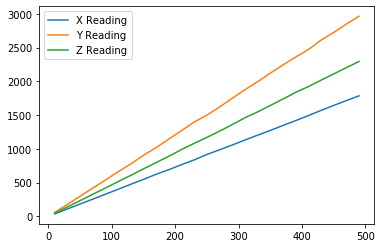

In [26]:
plt.plot(sample_size, mean_xval, label='X Reading')
plt.plot(sample_size, mean_yval, label='Y Reading')
plt.plot(sample_size, mean_zval, label='Z Reading')
plt.legend()

## Finding optimal m for each axis

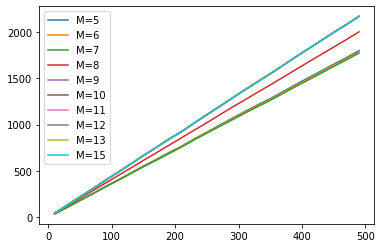

In [27]:
sample_size = list(range(10, 501, 20))
mean_x3 = []
mean_x4 = []
mean_x5 = []
mean_x6 = []
mean_x7 = []
mean_x8 = []
mean_x9 = []
mean_x10 = []
mean_x11 = []
mean_x12 = []
mean_x13 = []
mean_x15 = []

for i in sample_size:
    mean_x3.append(gol(i, x_values, m3_df, 200))
    mean_x4.append(gol(i, x_values, m4_df, 200))
    mean_x5.append(gol(i, x_values, m5_df, 200))
    mean_x6.append(gol(i, x_values, m6_df, 200))
    mean_x7.append(gol(i, x_values, m7_df, 200))
    mean_x8.append(gol(i, x_values, m8_df, 200))
    mean_x9.append(gol(i, x_values, m9_df, 200))
    mean_x10.append(gol(i, x_values, m10_df, 200))
    mean_x11.append(gol(i, x_values, m11_df, 200))
    mean_x12.append(gol(i, x_values, m12_df, 200))
    mean_x13.append(gol(i, x_values, m13_df, 200))
    mean_x15.append(gol(i, x_values, m15_df, 200))
    
plt.plot(sample_size, mean_x5, label='M=5')
plt.plot(sample_size, mean_x6, label='M=6')
plt.plot(sample_size, mean_x7, label='M=7')
plt.plot(sample_size, mean_x8, label='M=8')
plt.plot(sample_size, mean_x9, label='M=9')
plt.plot(sample_size, mean_x10, label='M=10')
plt.plot(sample_size, mean_x11, label='M=11')
plt.plot(sample_size, mean_x12, label='M=12')
plt.plot(sample_size, mean_x13, label='M=13')
plt.plot(sample_size, mean_x15, label='M=15')
plt.legend()
plt.show()

In [28]:
print('500 readings for X axis')
print('m = 3:', max(mean_x3), 'bits   -->', max(mean_x3)/8, 'Bytes')
print('m = 4:', max(mean_x4), 'bits   -->', max(mean_x4)/8, 'Bytes')
print('m = 5:', max(mean_x5), 'bits   -->', max(mean_x5)/8, 'Bytes')
print('m = 6:', max(mean_x6), 'bits   -->', max(mean_x6)/8, 'Bytes')
print('m = 7:', max(mean_x7), 'bits   -->', max(mean_x7)/8, 'Bytes')
print('m = 8:', max(mean_x8), 'bits   -->', max(mean_x8)/8, 'Bytes')
print('m = 9:', max(mean_x9), 'bits   -->', max(mean_x9)/8, 'Bytes')
print('m = 10:', max(mean_x10), 'bits  -->', max(mean_x10)/8, 'Bytes')
print('m = 11:', max(mean_x11), 'bits  -->', max(mean_x11)/8, 'Bytes')
print('m = 12:', max(mean_x12), 'bits  -->', max(mean_x12)/8, 'Bytes')
print('m = 13:', max(mean_x13), 'bits  -->', max(mean_x13)/8, 'Bytes')
print('m = 15:', max(mean_x15), 'bits  -->', max(mean_x15)/8, 'Bytes')

500 readings for X axis
m = 3: 1721.0 bits   --> 215.125 Bytes
m = 4: 1721.0 bits   --> 215.125 Bytes
m = 5: 1798.0 bits   --> 224.75 Bytes
m = 6: 1785.0 bits   --> 223.125 Bytes
m = 7: 1772.0 bits   --> 221.5 Bytes
m = 8: 2001.0 bits   --> 250.125 Bytes
m = 9: 2169.0 bits   --> 271.125 Bytes
m = 10: 2168.0 bits  --> 271.0 Bytes
m = 11: 2168.0 bits  --> 271.0 Bytes
m = 12: 2168.0 bits  --> 271.0 Bytes
m = 13: 2168.0 bits  --> 271.0 Bytes
m = 15: 2168.0 bits  --> 271.0 Bytes


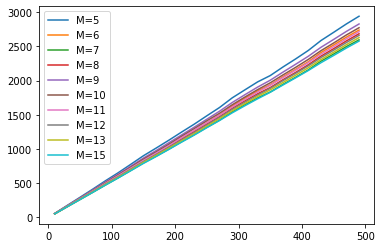

500 readings for Y axis
m = 3: 3605.0 bits   --> 450.625 Bytes
m = 4: 3134.0 bits   --> 391.75 Bytes
m = 5: 2940.0 bits   --> 367.5 Bytes
m = 6: 2738.0 bits   --> 342.25 Bytes
m = 7: 2595.0 bits   --> 324.375 Bytes
m = 8: 2684.0 bits   --> 335.5 Bytes
m = 9: 2827.0 bits   --> 353.375 Bytes
m = 10: 2772.0 bits  --> 346.5 Bytes
m = 11: 2715.0 bits  --> 339.375 Bytes
m = 12: 2660.0 bits  --> 332.5 Bytes
m = 13: 2628.0 bits  --> 328.5 Bytes
m = 15: 2577.0 bits  --> 322.125 Bytes


In [29]:
sample_size = list(range(10, 501, 20))
mean_y3 = []
mean_y4 = []
mean_y5 = []
mean_y6 = []
mean_y7 = []
mean_y8 = []
mean_y9 = []
mean_y10 = []
mean_y11 = []
mean_y12 = []
mean_y13 = []
mean_y15 = []

mean_y17 = []
mean_y19 = []
mean_y21 = []
mean_y23 = []
mean_y25 = []
mean_y27 = []
mean_y29 = []
mean_y31 = []
mean_y33 = []
mean_y35 = []
mean_y37 = []
mean_y39 = []

for i in sample_size:
    mean_y3.append(gol(i, y_values, m3_df, 200))
    mean_y4.append(gol(i, y_values, m4_df, 200))
    mean_y5.append(gol(i, y_values, m5_df, 200))
    mean_y6.append(gol(i, y_values, m6_df, 200))
    mean_y7.append(gol(i, y_values, m7_df, 200))
    mean_y8.append(gol(i, y_values, m8_df, 200))
    mean_y9.append(gol(i, y_values, m9_df, 200))
    mean_y10.append(gol(i, y_values, m10_df, 200))
    mean_y11.append(gol(i, y_values, m11_df, 200))
    mean_y12.append(gol(i, y_values, m12_df, 200))
    mean_y13.append(gol(i, y_values, m13_df, 200))
    mean_y15.append(gol(i, y_values, m15_df, 200))
    
    mean_y17.append(gol(i, y_values, m17_df, 200))
    mean_y19.append(gol(i, y_values, m19_df, 200))
    mean_y21.append(gol(i, y_values, m21_df, 200))
    mean_y23.append(gol(i, y_values, m23_df, 200))
    mean_y25.append(gol(i, y_values, m25_df, 200))
    mean_y27.append(gol(i, y_values, m27_df, 200))
    mean_y29.append(gol(i, y_values, m29_df, 200))
    mean_y31.append(gol(i, y_values, m31_df, 200))
    mean_y33.append(gol(i, y_values, m33_df, 200))
    mean_y35.append(gol(i, y_values, m35_df, 200))
    mean_y37.append(gol(i, y_values, m37_df, 200))
    mean_y39.append(gol(i, y_values, m39_df, 200))
    
plt.plot(sample_size, mean_y5, label='M=5')
plt.plot(sample_size, mean_y6, label='M=6')
plt.plot(sample_size, mean_y7, label='M=7')
plt.plot(sample_size, mean_y8, label='M=8')
plt.plot(sample_size, mean_y9, label='M=9')
plt.plot(sample_size, mean_y10, label='M=10')
plt.plot(sample_size, mean_y11, label='M=11')
plt.plot(sample_size, mean_y12, label='M=12')
plt.plot(sample_size, mean_y13, label='M=13')
plt.plot(sample_size, mean_y15, label='M=15')
plt.legend()
plt.show()

print('500 readings for Y axis')
print('m = 3:', max(mean_y3), 'bits   -->', max(mean_y3)/8, 'Bytes')
print('m = 4:', max(mean_y4), 'bits   -->', max(mean_y4)/8, 'Bytes')
print('m = 5:', max(mean_y5), 'bits   -->', max(mean_y5)/8, 'Bytes')
print('m = 6:', max(mean_y6), 'bits   -->', max(mean_y6)/8, 'Bytes')
print('m = 7:', max(mean_y7), 'bits   -->', max(mean_y7)/8, 'Bytes')
print('m = 8:', max(mean_y8), 'bits   -->', max(mean_y8)/8, 'Bytes')
print('m = 9:', max(mean_y9), 'bits   -->', max(mean_y9)/8, 'Bytes')
print('m = 10:', max(mean_y10), 'bits  -->', max(mean_y10)/8, 'Bytes')
print('m = 11:', max(mean_y11), 'bits  -->', max(mean_y11)/8, 'Bytes')
print('m = 12:', max(mean_y12), 'bits  -->', max(mean_y12)/8, 'Bytes')
print('m = 13:', max(mean_y13), 'bits  -->', max(mean_y13)/8, 'Bytes')
print('m = 15:', max(mean_y15), 'bits  -->', max(mean_y15)/8, 'Bytes')

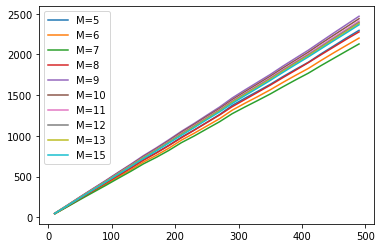

500 readings for z axis
m = 3: 2528.0 bits   --> 316.0 Bytes
m = 4: 2332.0 bits   --> 291.5 Bytes
m = 5: 2296.0 bits   --> 287.0 Bytes
m = 6: 2201.0 bits   --> 275.125 Bytes
m = 7: 2129.0 bits   --> 266.125 Bytes
m = 8: 2277.0 bits   --> 284.625 Bytes
m = 9: 2469.0 bits   --> 308.625 Bytes
m = 10: 2439.0 bits  --> 304.875 Bytes
m = 11: 2410.0 bits  --> 301.25 Bytes
m = 12: 2394.0 bits  --> 299.25 Bytes
m = 13: 2380.0 bits  --> 297.5 Bytes
m = 15: 2364.0 bits  --> 295.5 Bytes


In [30]:
sample_size = list(range(10, 501, 20))
mean_z3 = []
mean_z4 = []
mean_z5 = []
mean_z6 = []
mean_z7 = []
mean_z8 = []
mean_z9 = []
mean_z10 = []
mean_z11 = []
mean_z12 = []
mean_z13 = []
mean_z15 = []

mean_z17 = []
mean_z19 = []
mean_z21 = []
mean_z23 = []
mean_z25 = []
mean_z27 = []
mean_z29 = []
mean_z31 = []
mean_z33 = []
mean_z35 = []
mean_z37 = []
mean_z39 = []

for i in sample_size:
    mean_z3.append(gol(i, z_values, m3_df, 200))
    mean_z4.append(gol(i, z_values, m4_df, 200))
    mean_z5.append(gol(i, z_values, m5_df, 200))
    mean_z6.append(gol(i, z_values, m6_df, 200))
    mean_z7.append(gol(i, z_values, m7_df, 200))
    mean_z8.append(gol(i, z_values, m8_df, 200))
    mean_z9.append(gol(i, z_values, m9_df, 200))
    mean_z10.append(gol(i, z_values, m10_df, 200))
    mean_z11.append(gol(i, z_values, m11_df, 200))
    mean_z12.append(gol(i, z_values, m12_df, 200))
    mean_z13.append(gol(i, z_values, m13_df, 200))
    mean_z15.append(gol(i, z_values, m15_df, 200))
    
    mean_z17.append(gol(i, z_values, m17_df, 200))
    mean_z19.append(gol(i, z_values, m19_df, 200))
    mean_z21.append(gol(i, z_values, m21_df, 200))
    mean_z23.append(gol(i, z_values, m23_df, 200))
    mean_z25.append(gol(i, z_values, m25_df, 200))
    mean_z27.append(gol(i, z_values, m27_df, 200))
    mean_z29.append(gol(i, z_values, m29_df, 200))
    mean_z31.append(gol(i, z_values, m31_df, 200))
    mean_z33.append(gol(i, z_values, m33_df, 200))
    mean_z35.append(gol(i, z_values, m35_df, 200))
    mean_z37.append(gol(i, z_values, m37_df, 200))
    mean_z39.append(gol(i, z_values, m39_df, 200))
    
plt.plot(sample_size, mean_z5, label='M=5')
plt.plot(sample_size, mean_z6, label='M=6')
plt.plot(sample_size, mean_z7, label='M=7')
plt.plot(sample_size, mean_z8, label='M=8')
plt.plot(sample_size, mean_z9, label='M=9')
plt.plot(sample_size, mean_z10, label='M=10')
plt.plot(sample_size, mean_z11, label='M=11')
plt.plot(sample_size, mean_z12, label='M=12')
plt.plot(sample_size, mean_z13, label='M=13')
plt.plot(sample_size, mean_z15, label='M=15')
plt.legend()
plt.show()

print('500 readings for z axis')
print('m = 3:', max(mean_z3), 'bits   -->', max(mean_z3)/8, 'Bytes')
print('m = 4:', max(mean_z4), 'bits   -->', max(mean_z4)/8, 'Bytes')
print('m = 5:', max(mean_z5), 'bits   -->', max(mean_z5)/8, 'Bytes')
print('m = 6:', max(mean_z6), 'bits   -->', max(mean_z6)/8, 'Bytes')
print('m = 7:', max(mean_z7), 'bits   -->', max(mean_z7)/8, 'Bytes')
print('m = 8:', max(mean_z8), 'bits   -->', max(mean_z8)/8, 'Bytes')
print('m = 9:', max(mean_z9), 'bits   -->', max(mean_z9)/8, 'Bytes')
print('m = 10:', max(mean_z10), 'bits  -->', max(mean_z10)/8, 'Bytes')
print('m = 11:', max(mean_z11), 'bits  -->', max(mean_z11)/8, 'Bytes')
print('m = 12:', max(mean_z12), 'bits  -->', max(mean_z12)/8, 'Bytes')
print('m = 13:', max(mean_z13), 'bits  -->', max(mean_z13)/8, 'Bytes')
print('m = 15:', max(mean_z15), 'bits  -->', max(mean_z15)/8, 'Bytes')

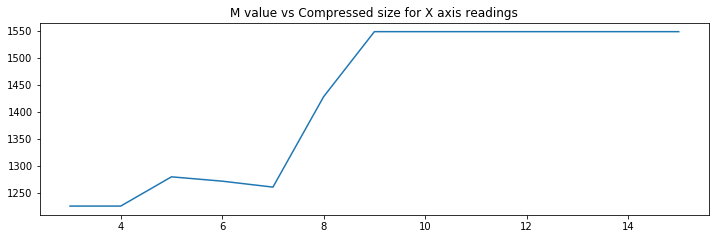

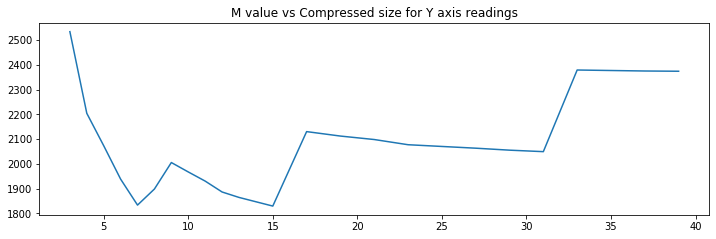

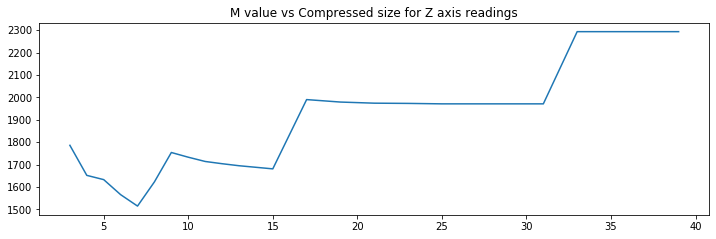

In [31]:
from pylab import rcParams
import matplotlib.gridspec as gridspec
rcParams['figure.figsize'] = 12, 12 # width, height (both in inches[17]
gs = gridspec.GridSpec(3, 1) # 3 row, 1 columns

mx = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15]
size_x = [mean_x3[17], mean_x4[17], mean_x5[17], mean_x6[17], mean_x7[17],
         mean_x8[17], mean_x9[17], mean_x10[17], mean_x11[17], mean_x12[17],
         mean_x13[17], mean_x15[17]]

fig = plt.figure()
ax = fig.add_subplot(gs[0, 0])
ax.plot(mx, size_x)
ax.title.set_text('M value vs Compressed size for X axis readings')

my = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 19, 21, 23,
     25, 27, 29, 31, 33, 35, 37, 39]
size_y = [mean_y3[17], mean_y4[17], mean_y5[17], mean_y6[17], mean_y7[17],
         mean_y8[17], mean_y9[17], mean_y10[17], mean_y11[17], mean_y12[17],
         mean_y13[17], mean_y15[17], mean_y17[17], mean_y19[17], mean_y21[17],
         mean_y23[17], mean_y25[17], mean_y27[17], mean_y29[17], mean_y31[17],
         mean_y33[17], mean_y35[17], mean_y37[17], mean_y39[17]]

fig = plt.figure()
ax = fig.add_subplot(gs[1, 0])
ax.plot(my, size_y)
ax.title.set_text('M value vs Compressed size for Y axis readings')


mz = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 19, 21, 23,
     25, 27, 29, 31, 33, 35, 37, 39]
size_z = [mean_z3[17], mean_z4[17], mean_z5[17], mean_z6[17], mean_z7[17],
         mean_z8[17], mean_z9[17], mean_z10[17], mean_z11[17], mean_z12[17],
         mean_z13[17], mean_z15[17], mean_z17[17], mean_z19[17], mean_z21[17],
         mean_z23[17], mean_z25[17], mean_z27[17], mean_z29[17], mean_z31[17],
         mean_z33[17], mean_z35[17], mean_z37[17], mean_z39[17]]

fig = plt.figure()
ax = fig.add_subplot(gs[2, 0])
ax.plot(mz, size_z)
ax.title.set_text('M value vs Compressed size for Z axis readings')

# plt.suptitle('350 Samples')
plt.show()

In [32]:
print('350 Readings (Graphs above):')
print(min(size_x) + min(size_y) + min(size_z), 'bits')
print((min(size_x) + min(size_y) + min(size_z))/8, 'Bytes')

350 Readings (Graphs above):
4570.0 bits
571.25 Bytes


In [33]:
gol_size_df = pd.DataFrame(columns=['sample_size', 'best_m_x', 'best_m_y', 'best_m_z',
                                    'x_size', 'y_size', 'z_size', 'tot_bits', 'tot_bytes'])

for i in range(len(sample_size)):
    mx_t = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15]
    size_x_t = [mean_x3[i], mean_x4[i], mean_x5[i], mean_x6[i], mean_x7[i],
             mean_x8[i], mean_x9[i], mean_x10[i], mean_x11[i], mean_x12[i],
             mean_x13[i], mean_x15[i]]
    
    my_t = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 19, 21, 23,
         25, 27, 29, 31, 33, 35, 37, 39]
    size_y_t = [mean_y3[i], mean_y4[i], mean_y5[i], mean_y6[i], mean_y7[i],
             mean_y8[i], mean_y9[i], mean_y10[i], mean_y11[i], mean_y12[i],
             mean_y13[i], mean_y15[i], mean_y17[i], mean_y19[i], mean_y21[i],
             mean_y23[i], mean_y25[i], mean_y27[i], mean_y29[i], mean_y31[i],
             mean_y33[i], mean_y35[i], mean_y37[i], mean_y39[i]]
    
    mz_t = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 19, 21, 23,
         25, 27, 29, 31, 33, 35, 37, 39]
    size_z_t = [mean_z3[i], mean_z4[i], mean_z5[i], mean_z6[i], mean_z7[i],
             mean_z8[i], mean_z9[i], mean_z10[i], mean_z11[i], mean_z12[i],
             mean_z13[i], mean_z15[i], mean_z17[i], mean_z19[i], mean_z21[i],
             mean_z23[i], mean_z25[i], mean_z27[i], mean_z29[i], mean_z31[i],
             mean_z33[i], mean_z35[i], mean_z37[i], mean_z39[i]]
    
    best_mx = mx_t[size_x_t.index(min(size_x_t))]
    best_my = my_t[size_y_t.index(min(size_y_t))]
    best_mz = mz_t[size_z_t.index(min(size_z_t))]
    tot = min(size_x_t) + min(size_y_t) + min(size_z_t)
    
    gol_size_df = gol_size_df.append(pd.DataFrame(data=[[sample_size[i], best_mx, best_my, best_mz,
                                                       min(size_x_t), min(size_y_t), min(size_z_t), tot, tot/8]],
                                                 columns=['sample_size', 'best_m_x', 'best_m_y', 'best_m_z',
                                                         'x_size', 'y_size', 'z_size', 'tot_bits', 'tot_bytes']))
    
gol_size_df

,sample_size,best_m_x,best_m_y,best_m_z,x_size,y_size,z_size,tot_bits,tot_bytes
0,10,3,7,7,33.400000,50.800000,42.700000,126.900000,15.862500
0,30,3,15,7,103.142857,156.142857,129.857143,389.142857,48.642857
0,50,3,15,7,172.250000,260.250000,218.250000,650.750000,81.343750
0,70,3,15,7,242.333333,365.333333,304.666667,912.333333,114.041667
0,90,3,15,7,316.000000,471.666667,390.333333,1178.000000,147.250000
0,110,3,15,7,383.000000,575.000000,479.000000,1437.000000,179.625000
0,130,4,15,7,455.500000,682.000000,565.500000,1703.000000,212.875000
0,150,4,15,7,529.000000,789.000000,657.000000,1975.000000,246.875000
0,170,3,15,7,595.000000,889.500000,736.000000,2220.500000,277.562500
0,190,4,15,7,668.000000,993.000000,822.000000,2483.000000,310.375000


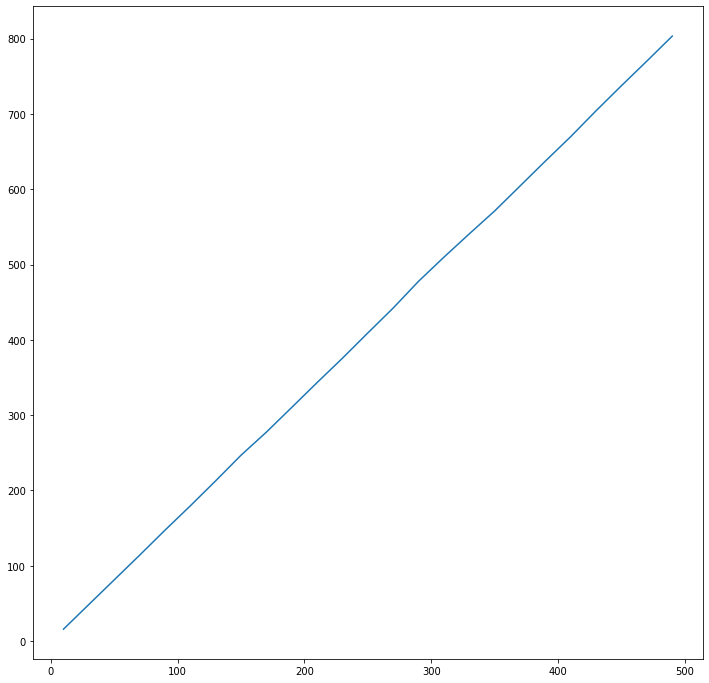

In [34]:
plt.plot(gol_size_df['sample_size'], gol_size_df['tot_bytes'])

In [35]:
gol_size_df.describe()

,x_size,y_size,z_size,tot_bits,tot_bytes
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,877.185048,1311.387714,1085.852286,3274.425048,409.303131
std,517.859962,773.860264,638.123379,1929.828791,241.228599
min,33.400000,50.800000,42.700000,126.900000,15.862500
25%,455.500000,682.000000,565.500000,1703.000000,212.875000
50%,876.000000,1311.000000,1087.000000,3274.000000,409.250000
75%,1297.000000,1935.000000,1603.000000,4835.000000,604.375000
max,1721.000000,2577.000000,2129.000000,6427.000000,803.375000
